#Code for backtesting with indicator filters in first tab, next tab contains code for cobination of indicator filters 

#Results for first are in backtest_results_summary.csv
#Results for second are in backtest_results_summary1.csv

Connected to MetaTrader 5


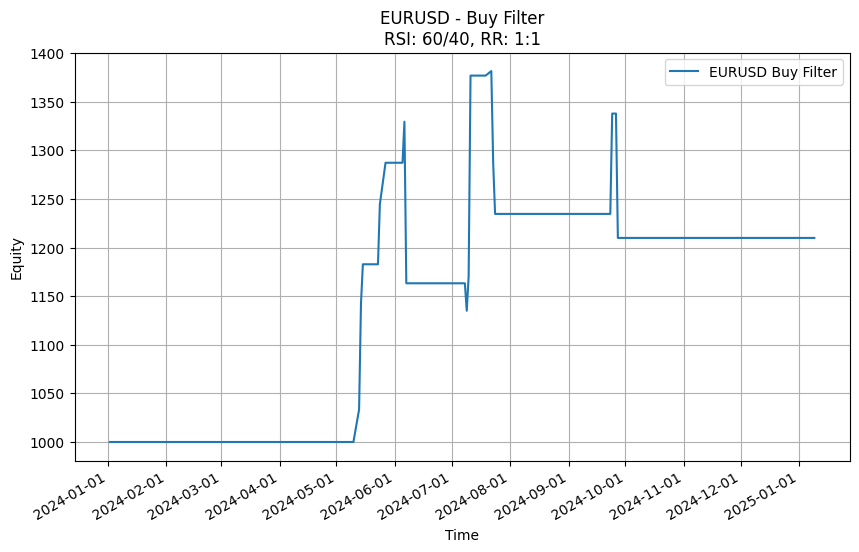

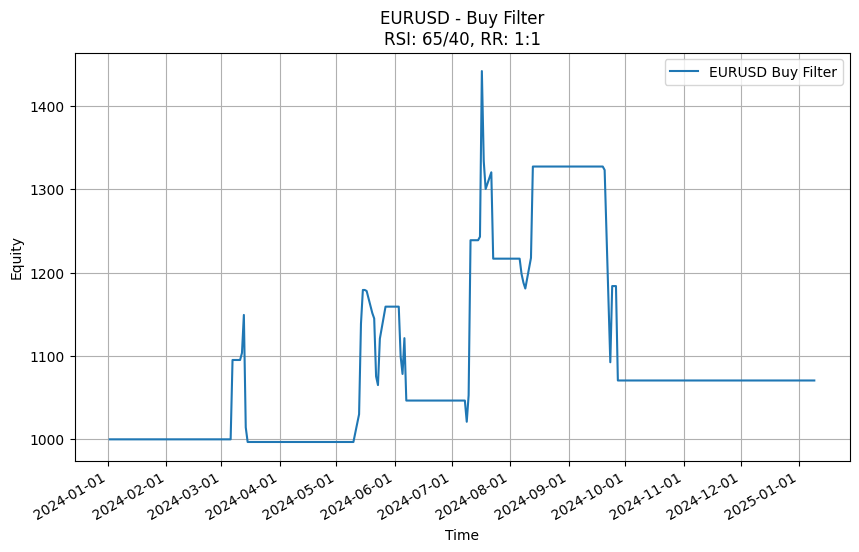

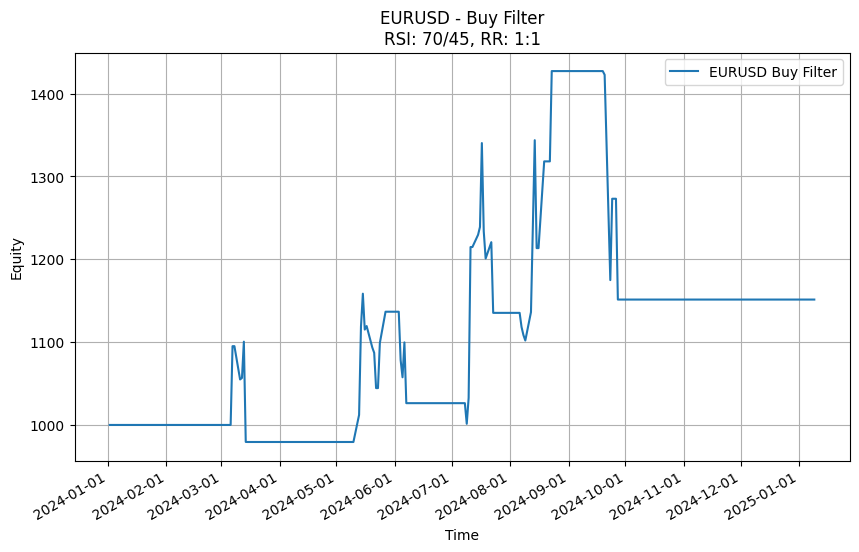

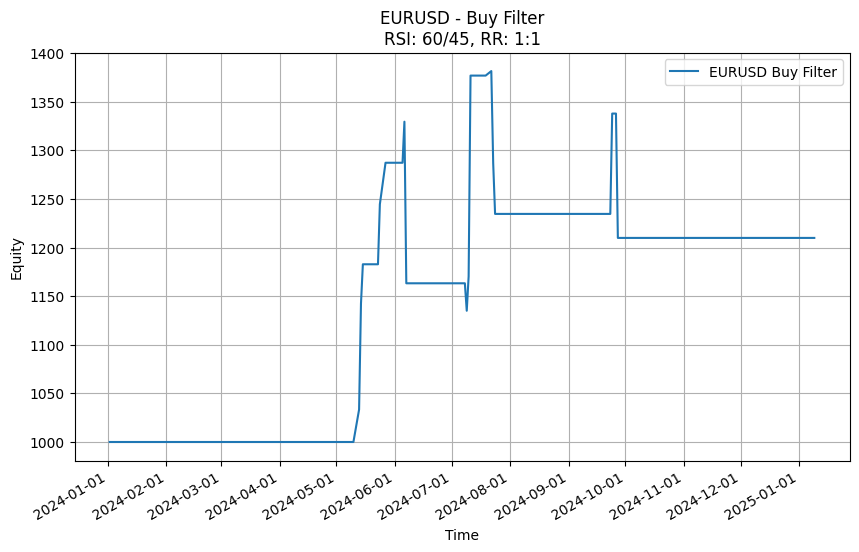

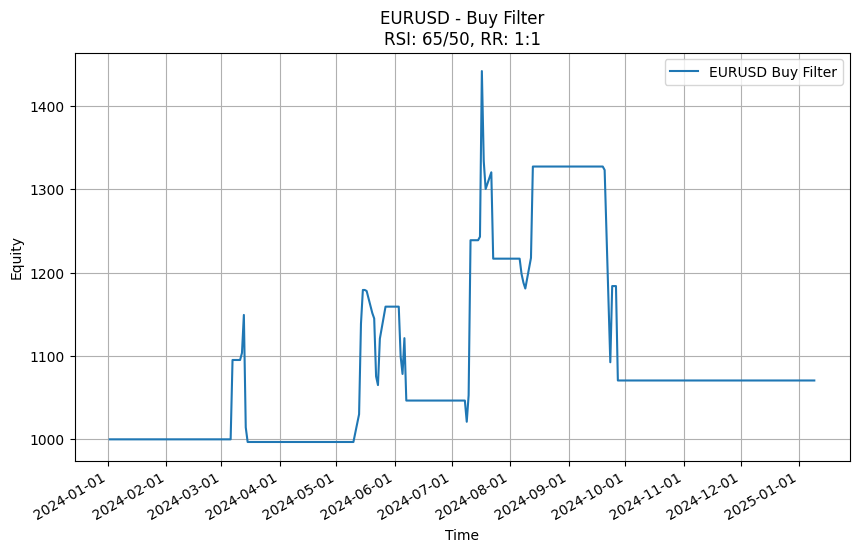

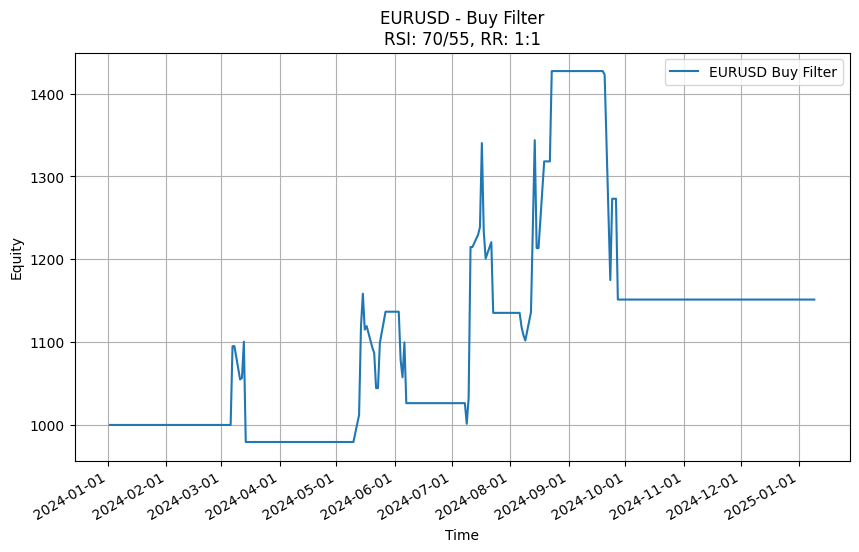

c:\ProgramData\anaconda3\envs\forex_env\Lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: divide by zero encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


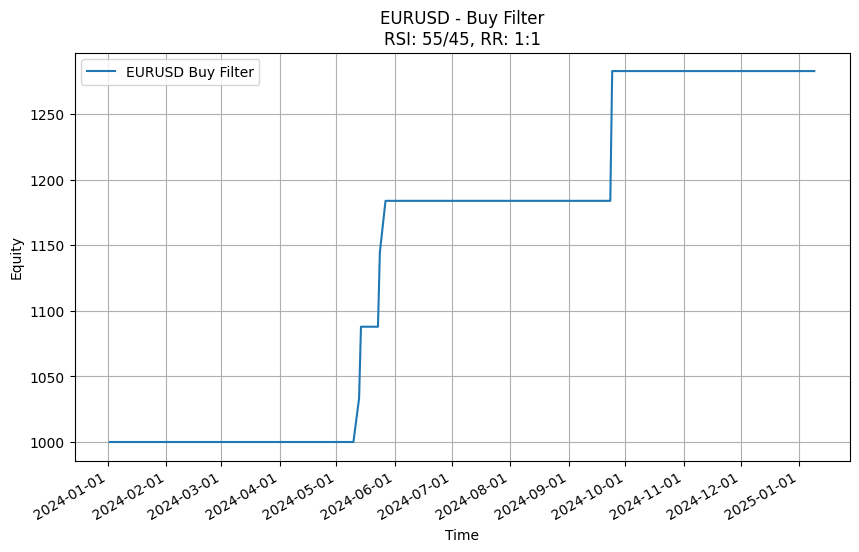

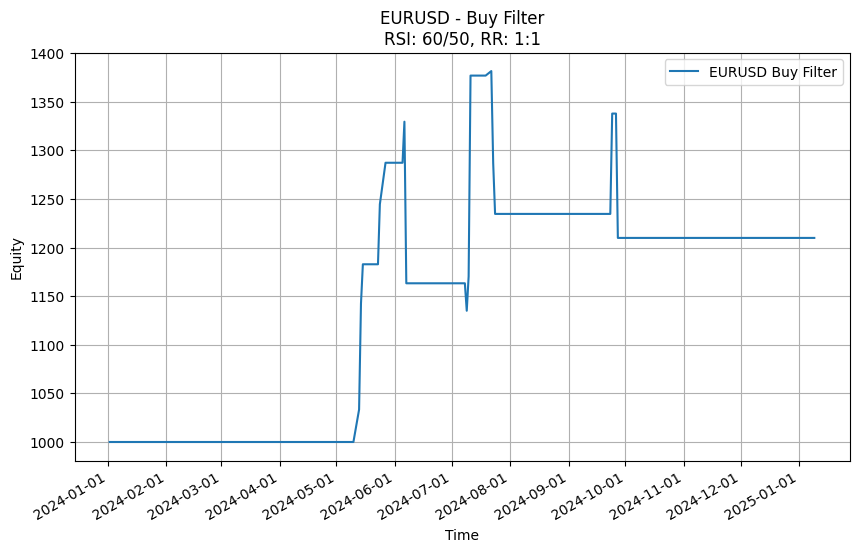

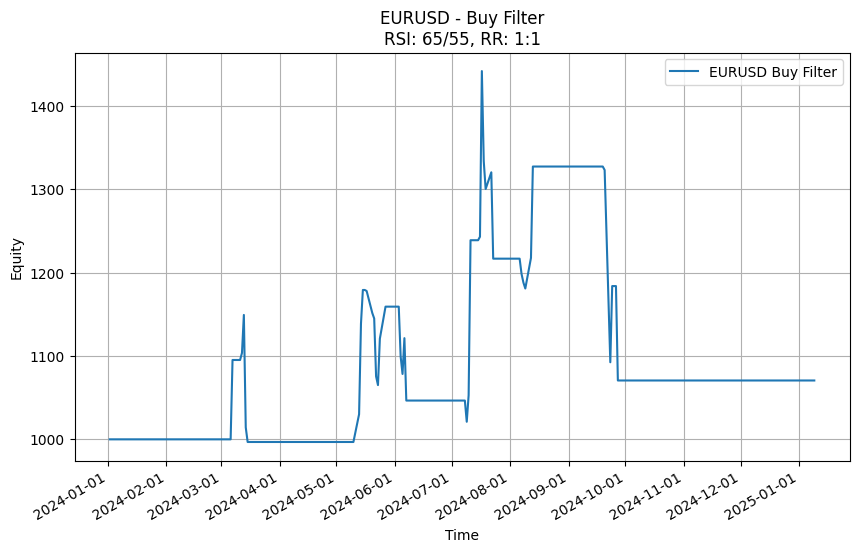

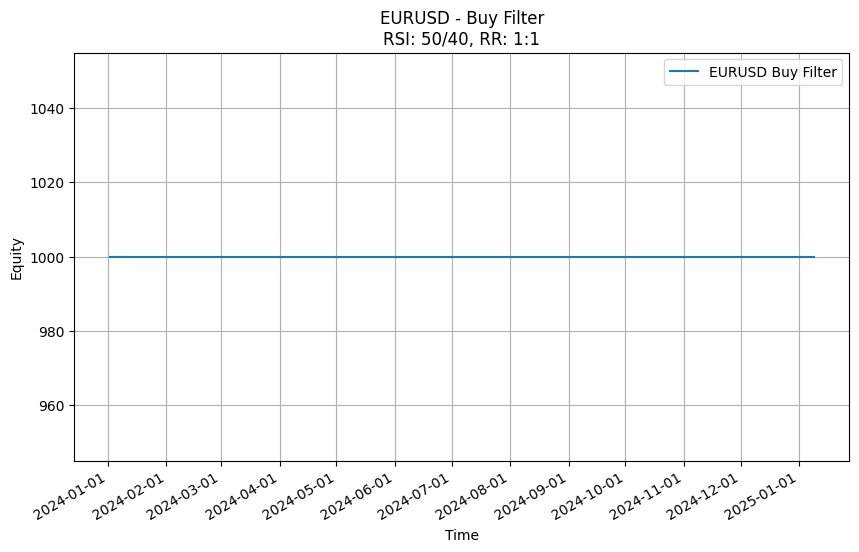

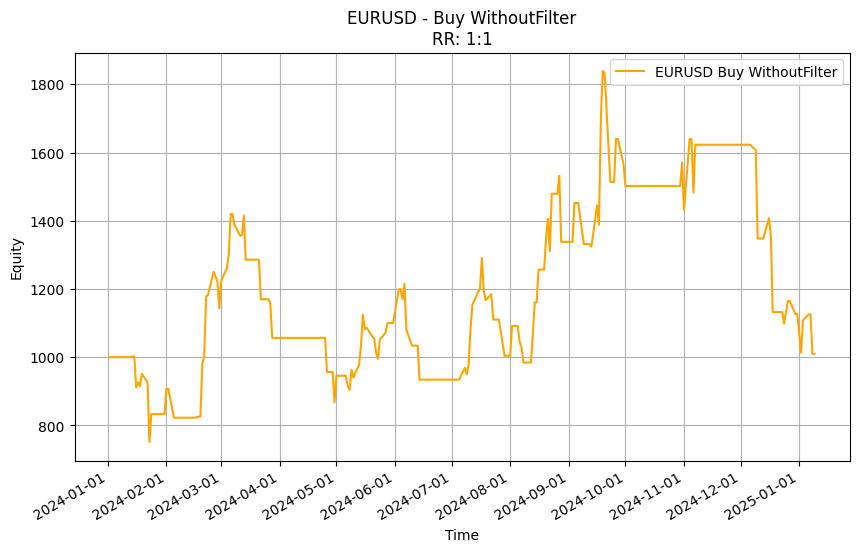

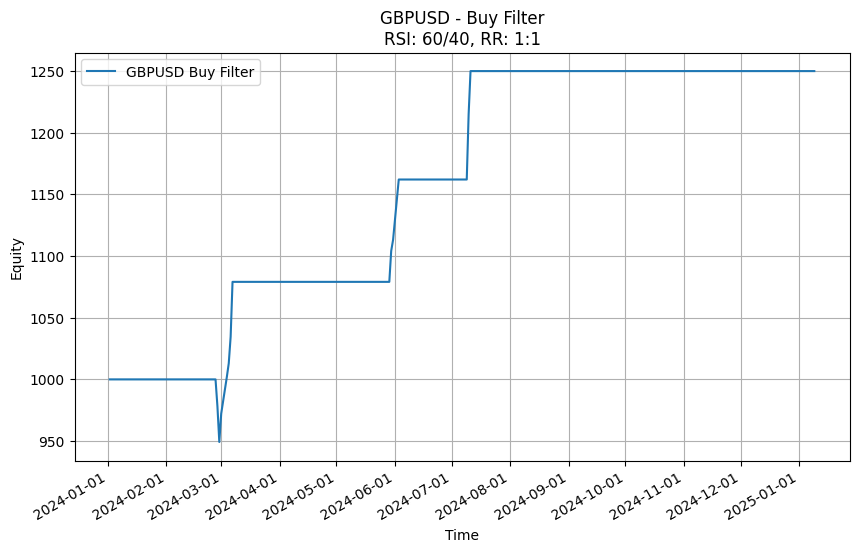

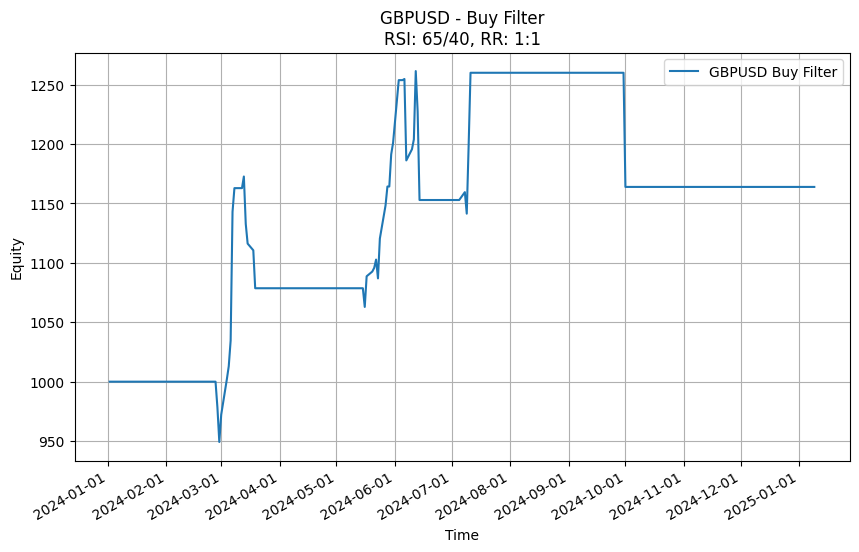

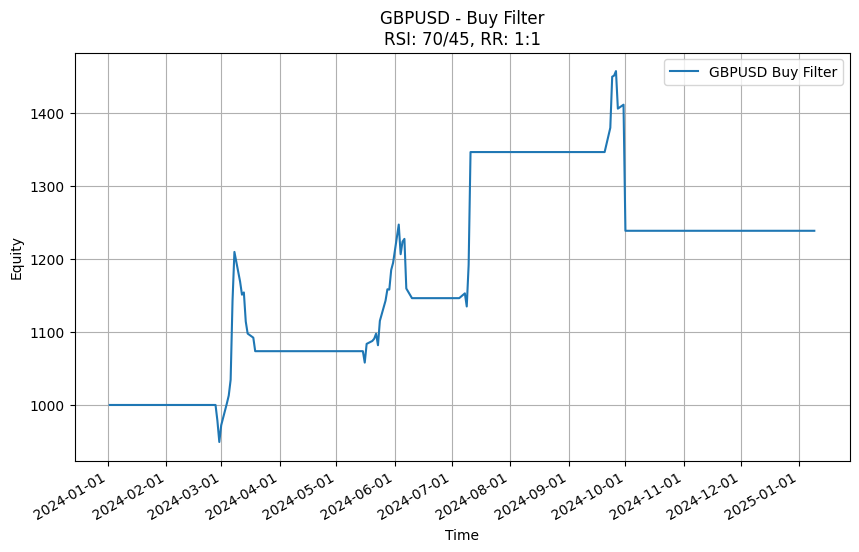

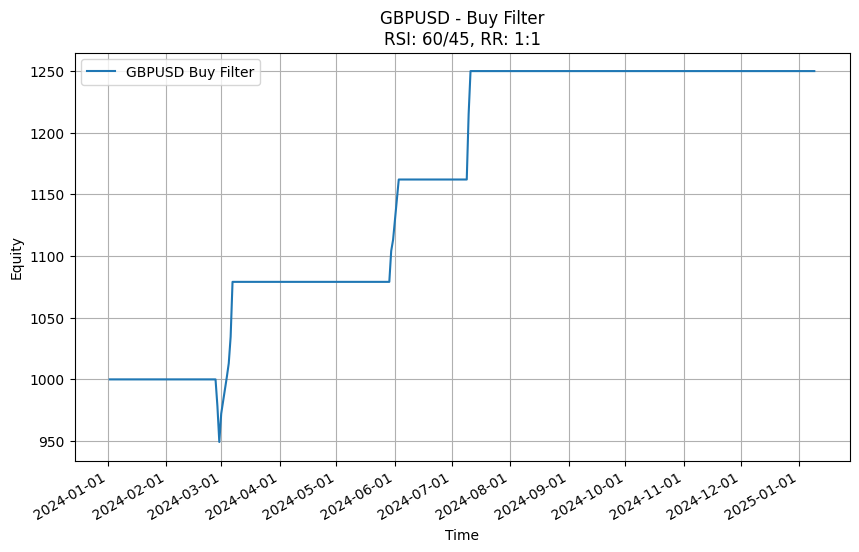

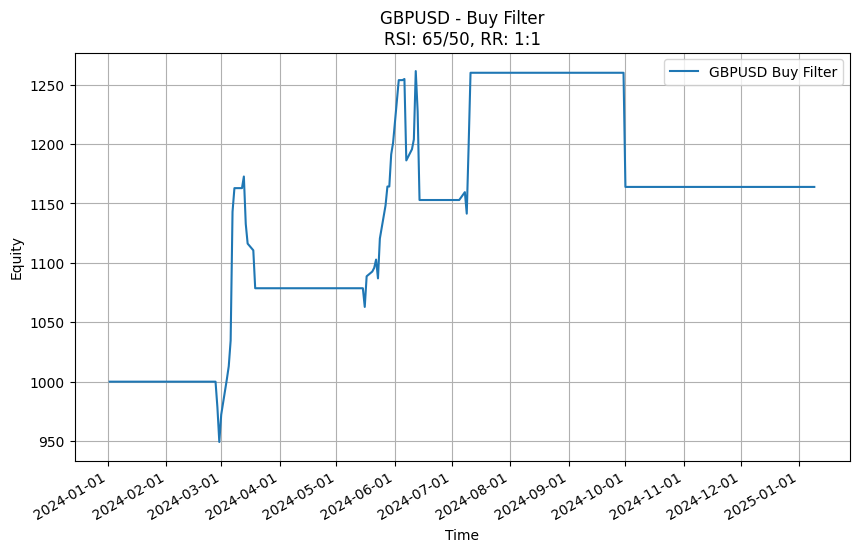

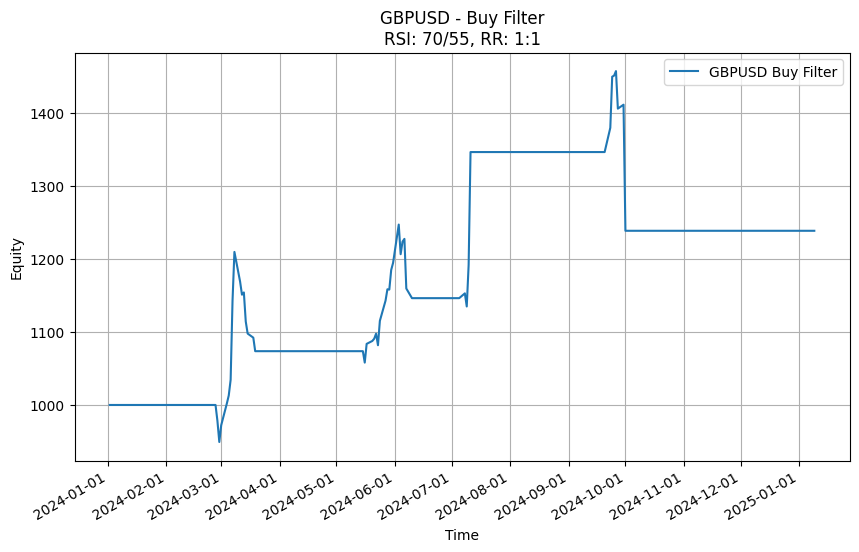

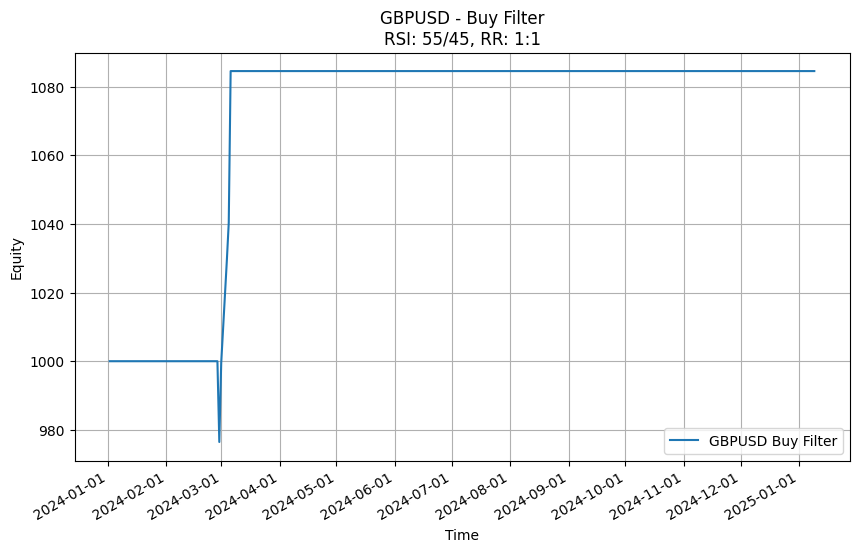

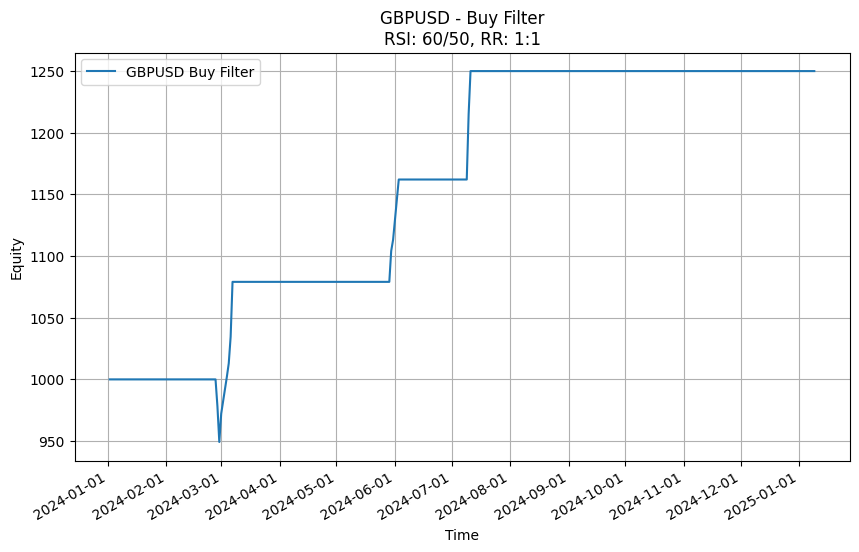

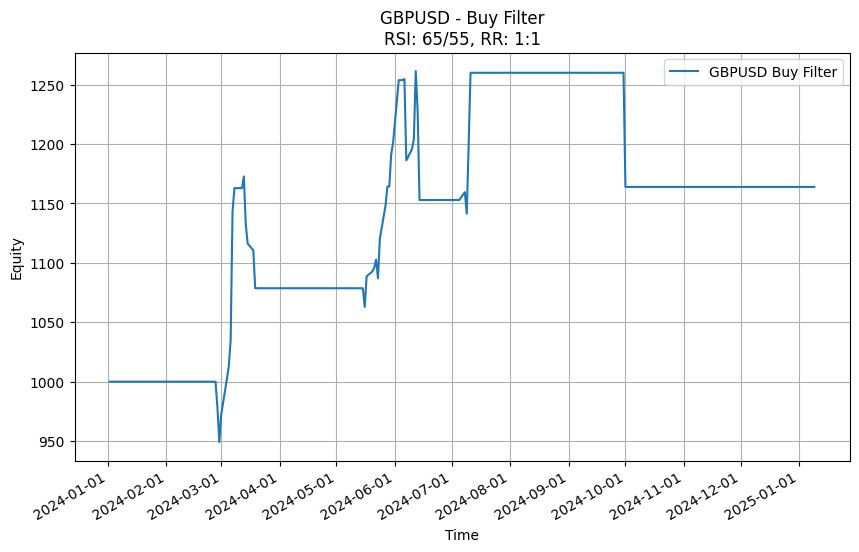

c:\ProgramData\anaconda3\envs\forex_env\Lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: divide by zero encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


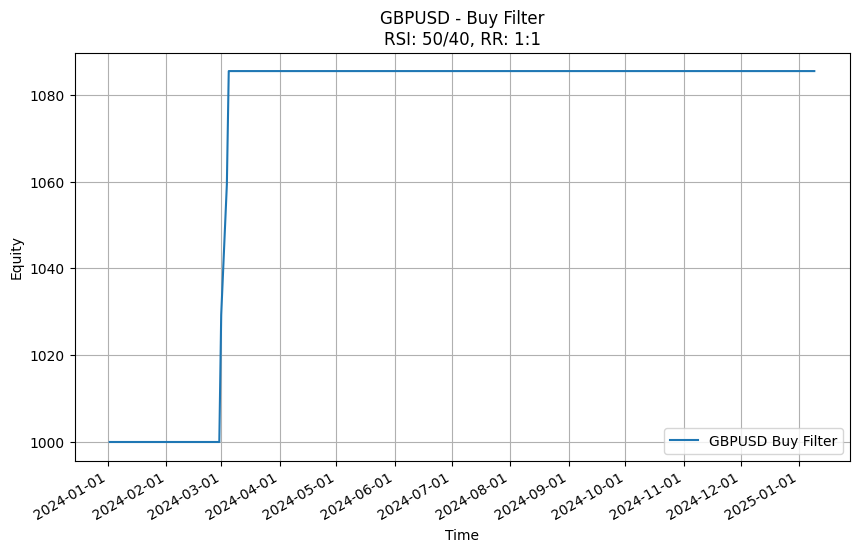

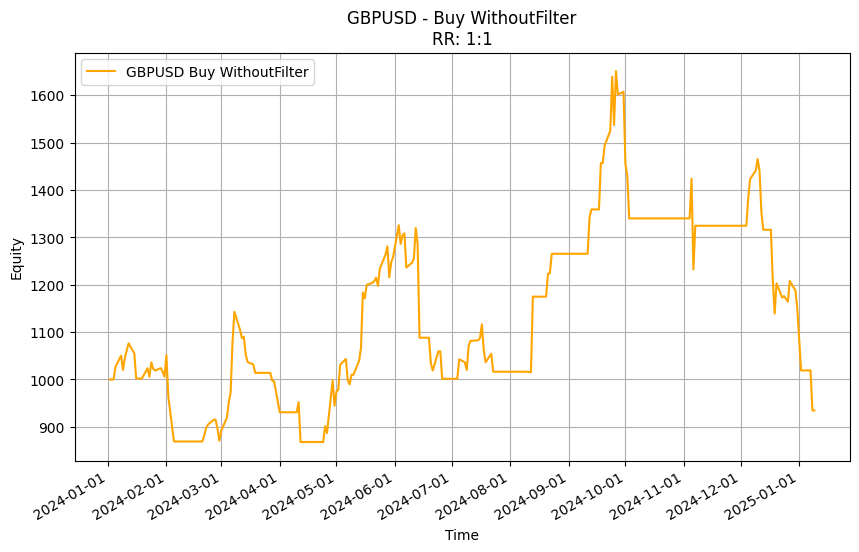

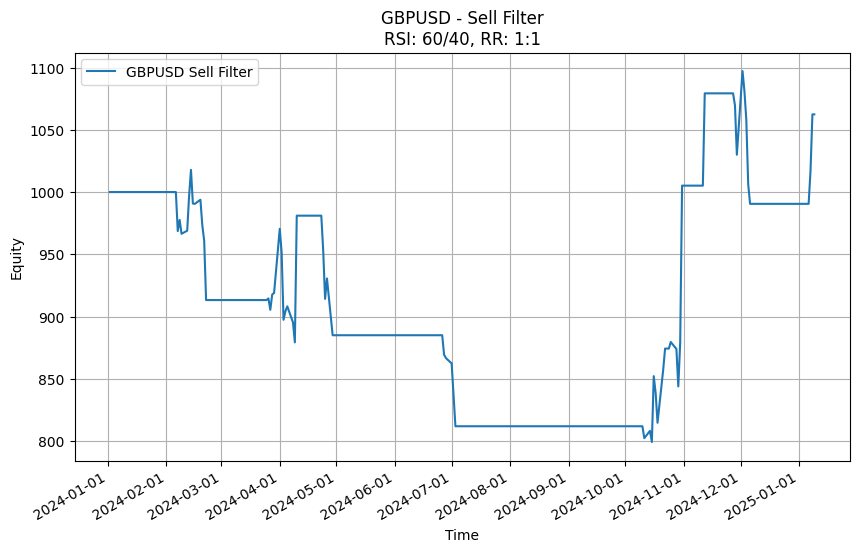

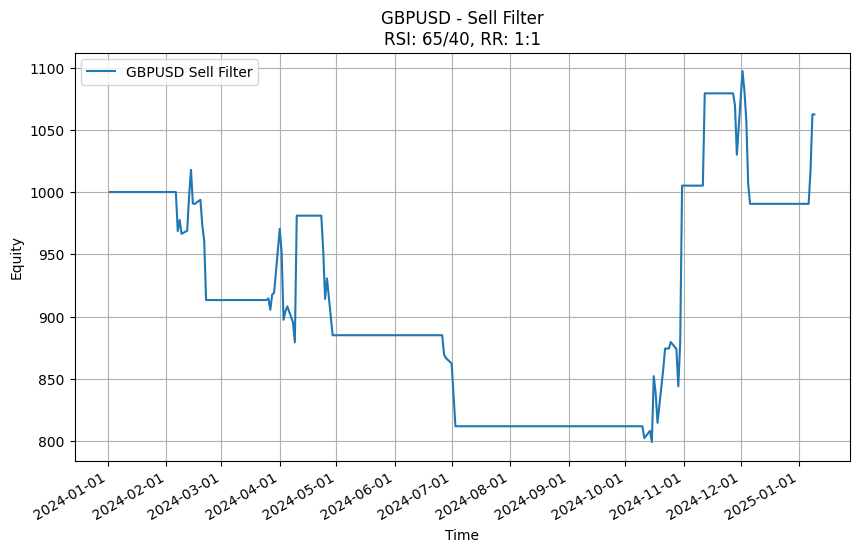

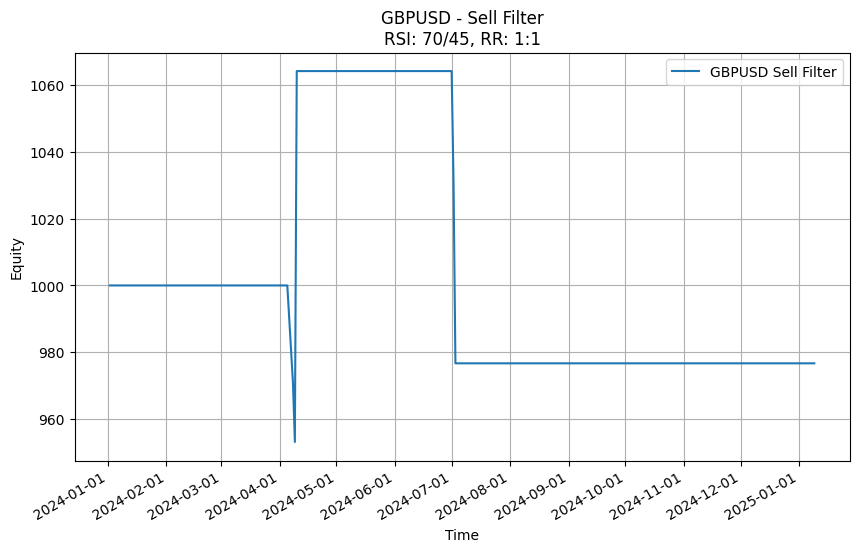

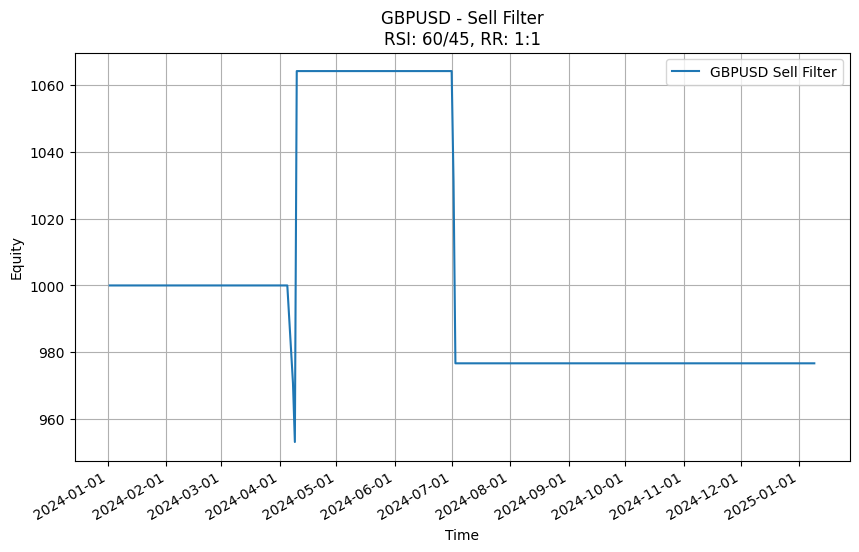

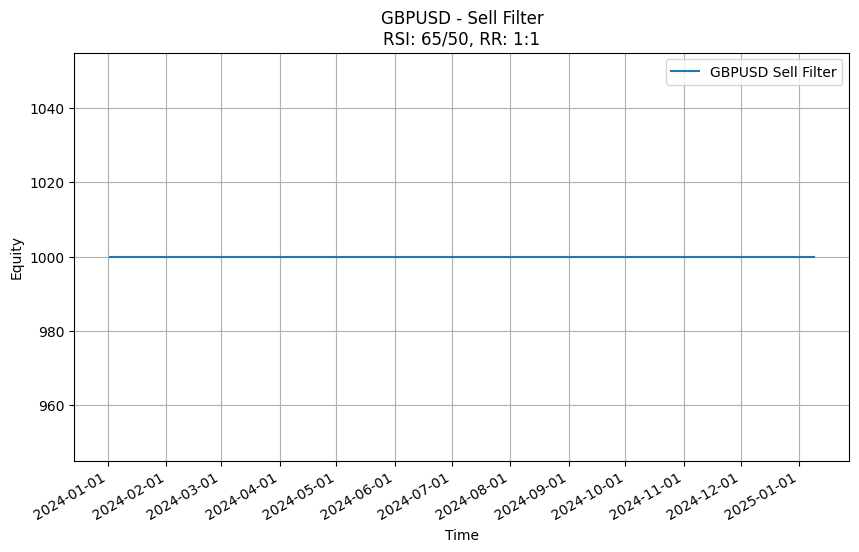

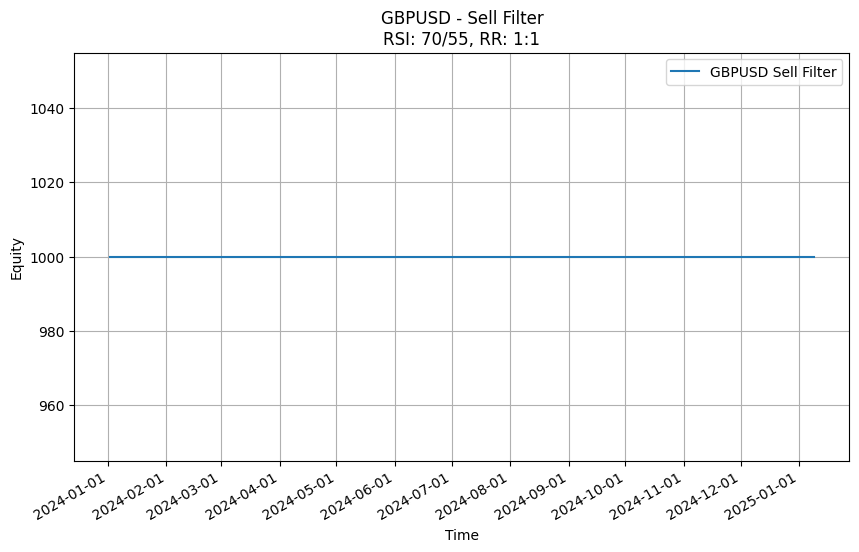

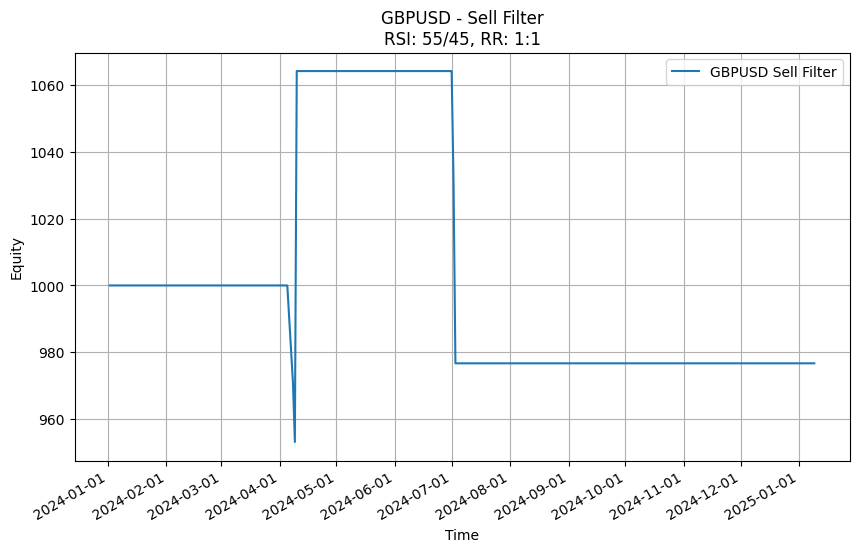

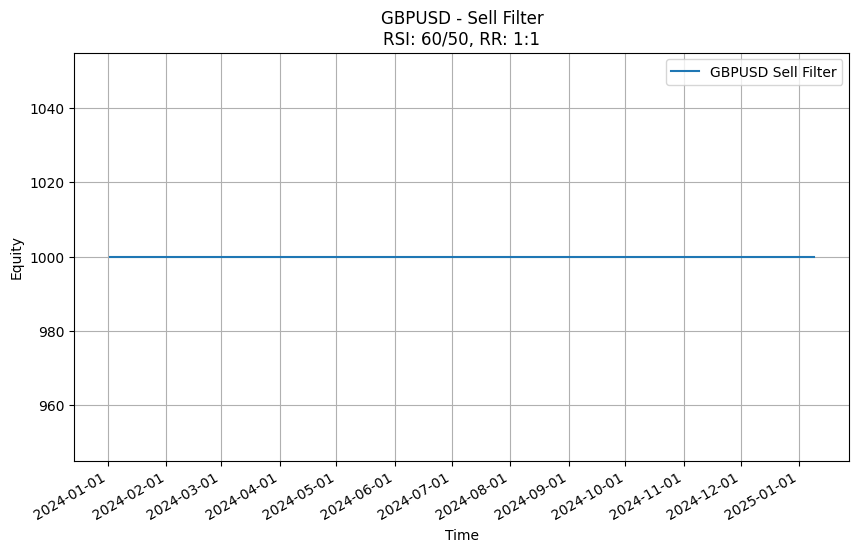

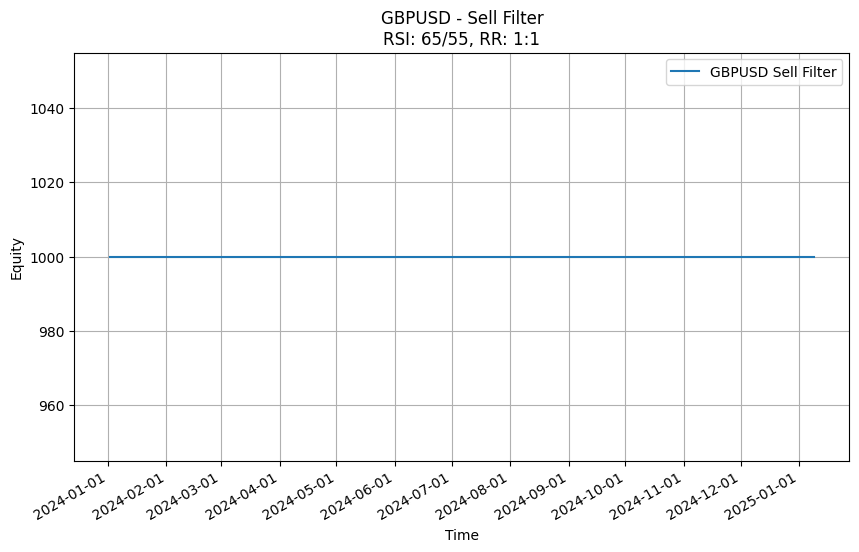

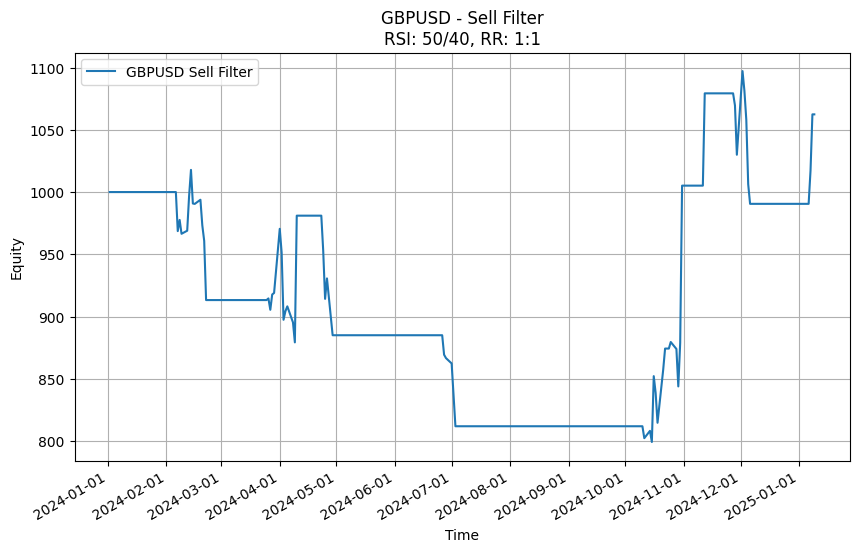

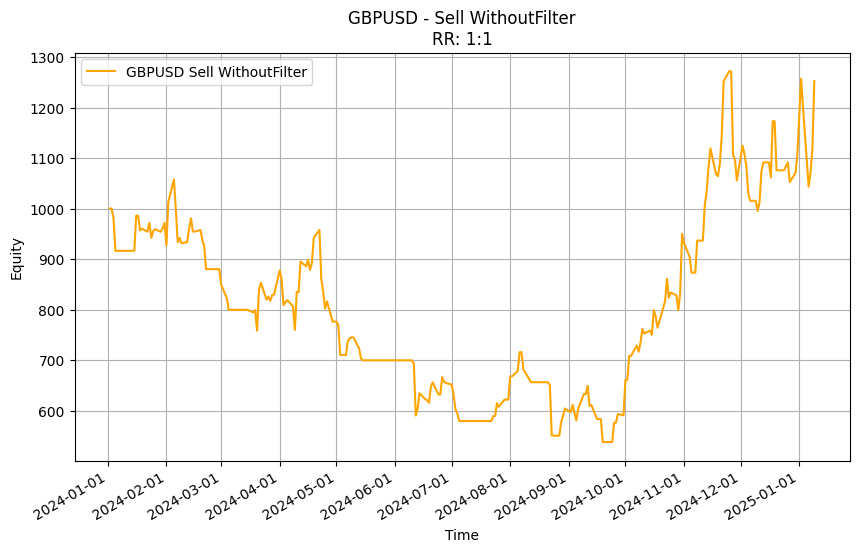

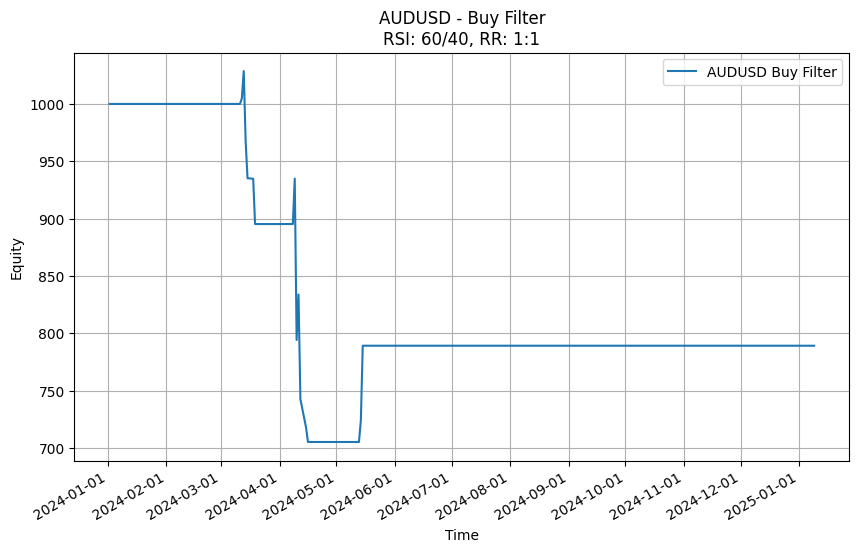

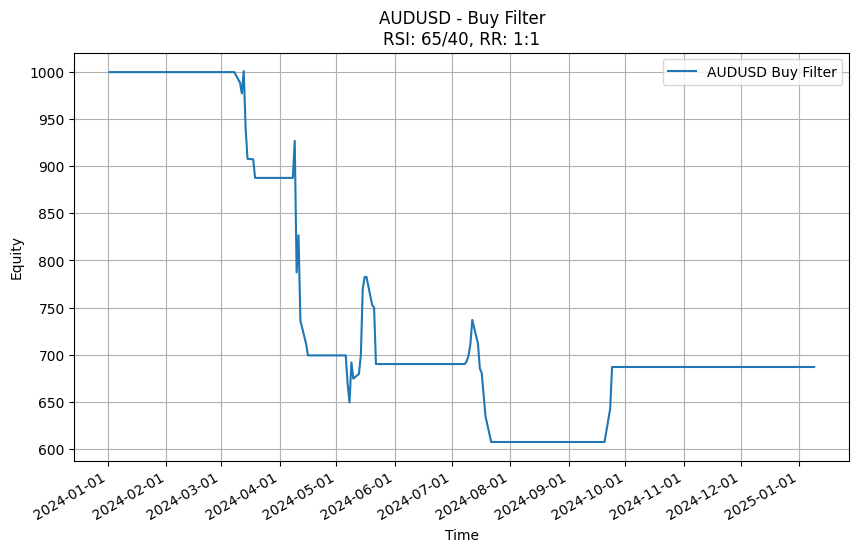

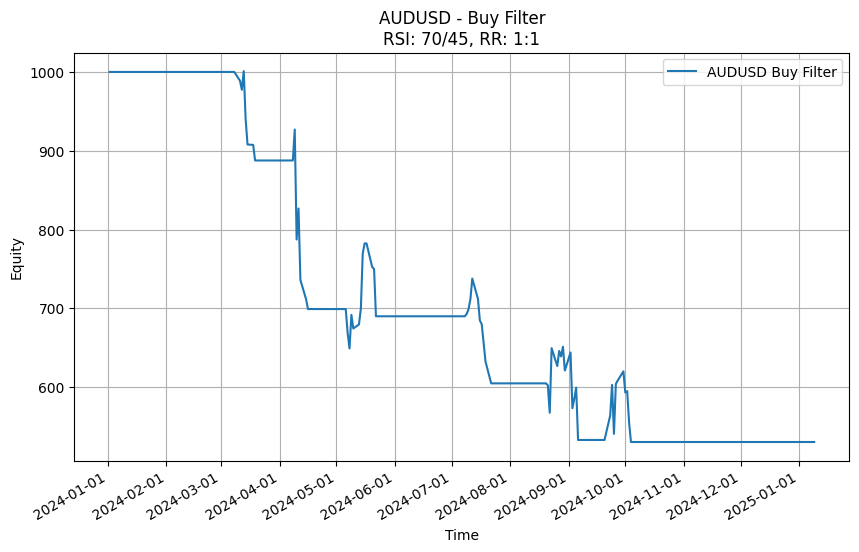

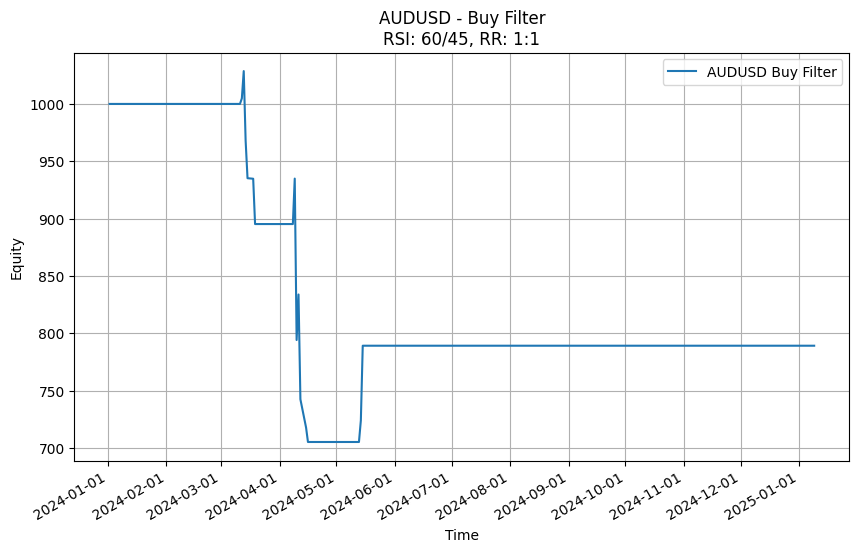

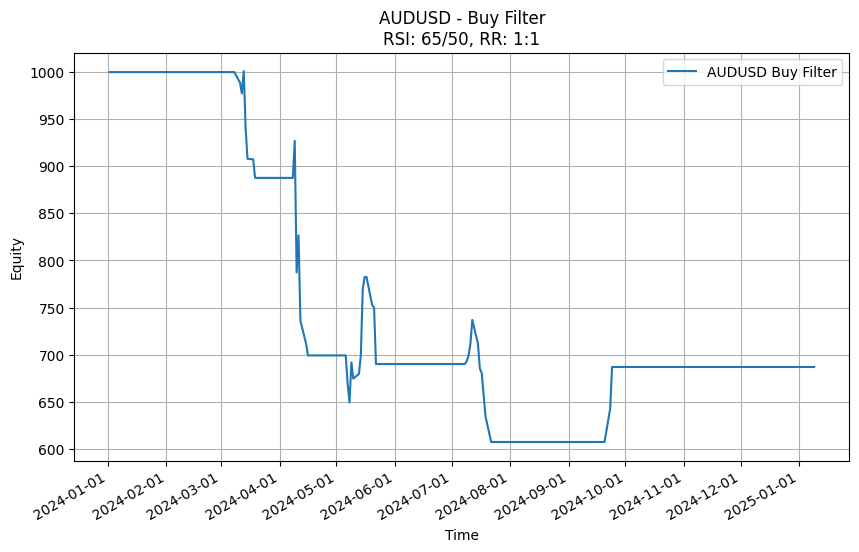

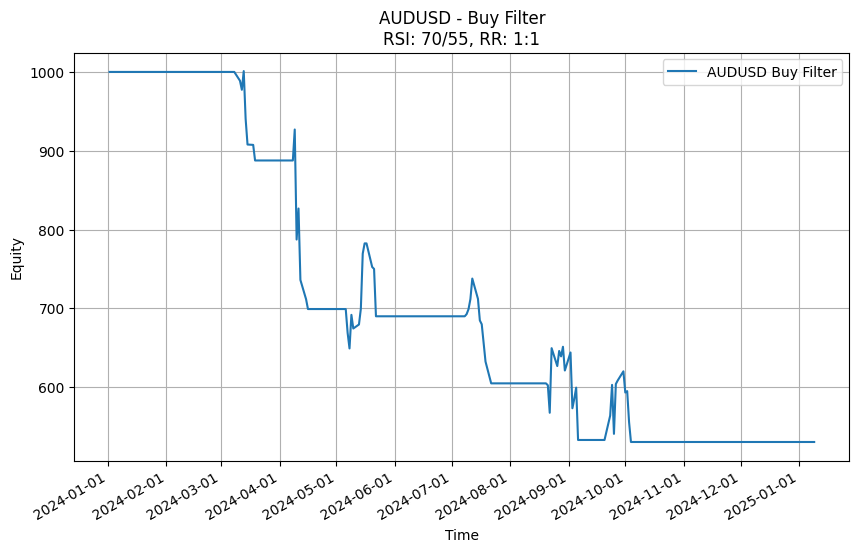

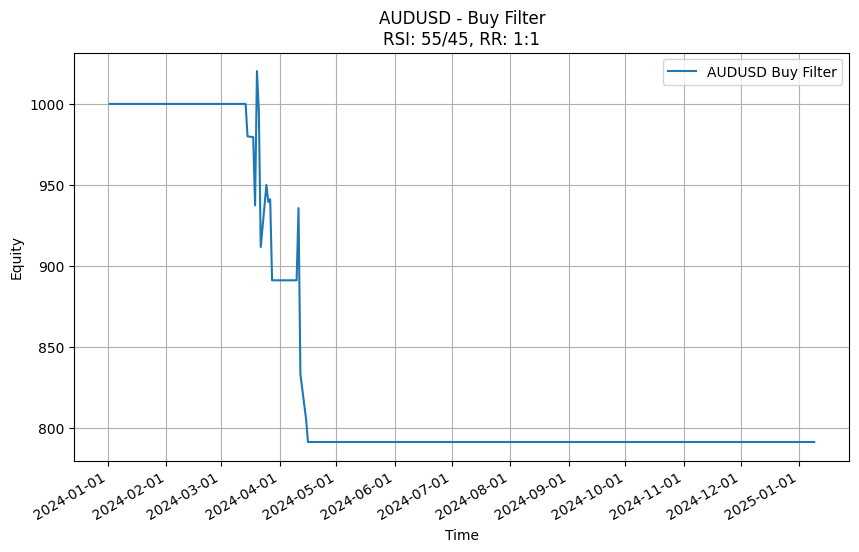

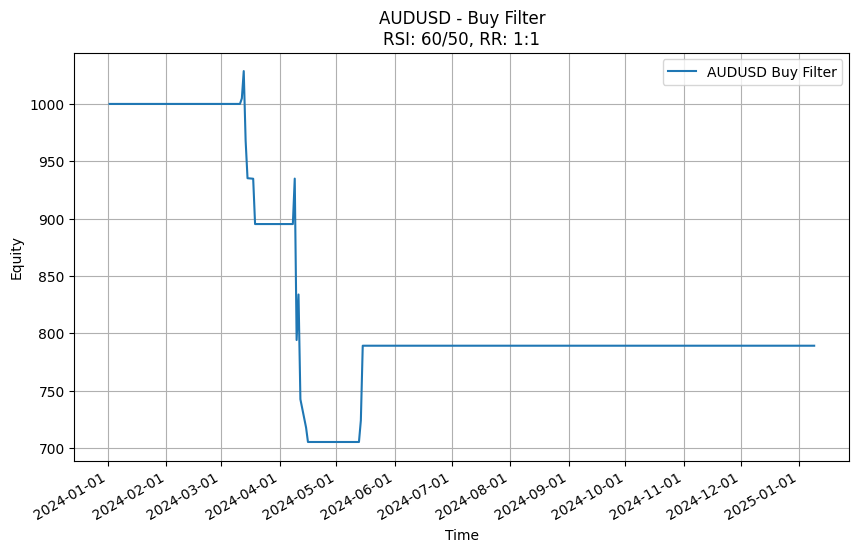

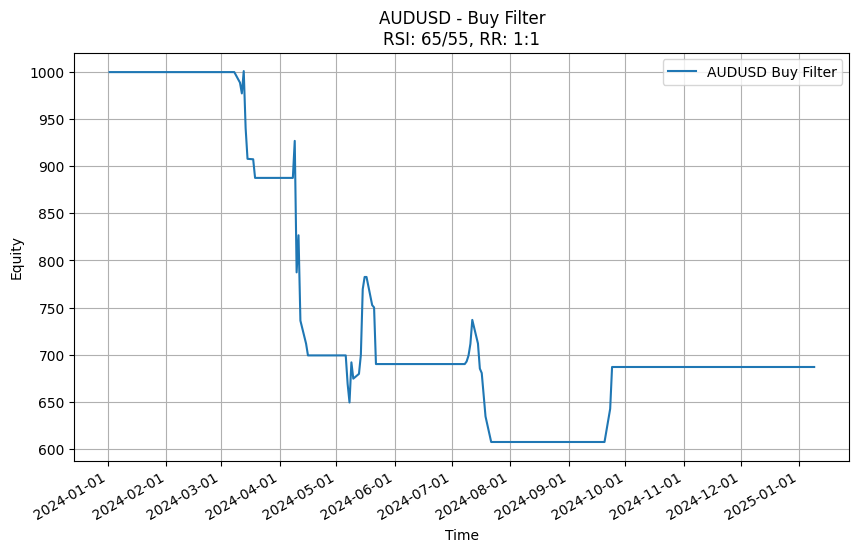

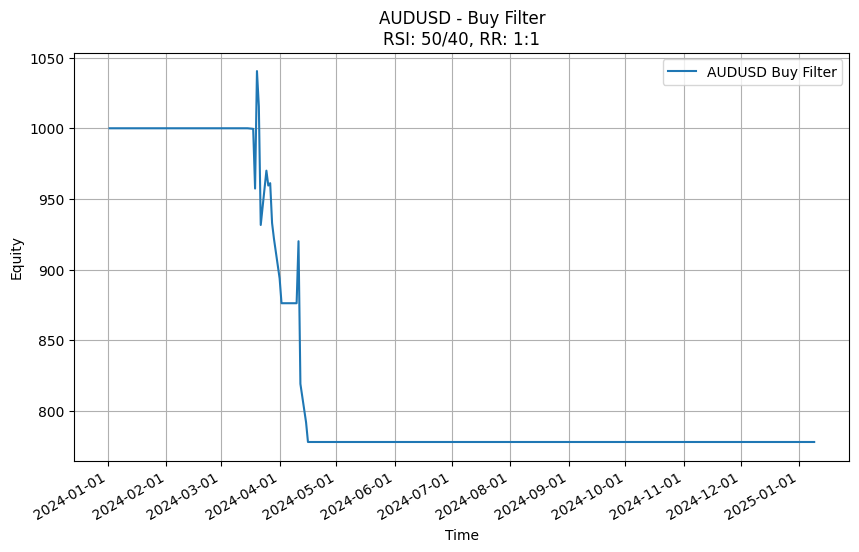

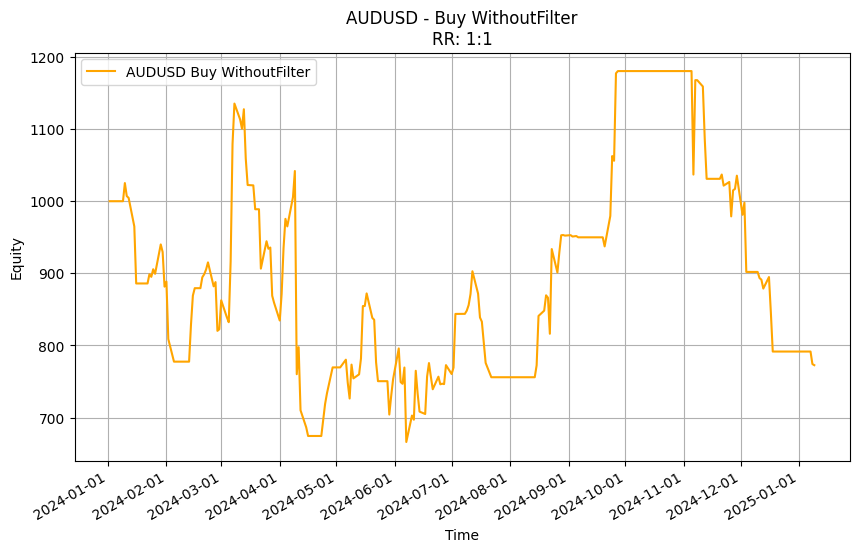

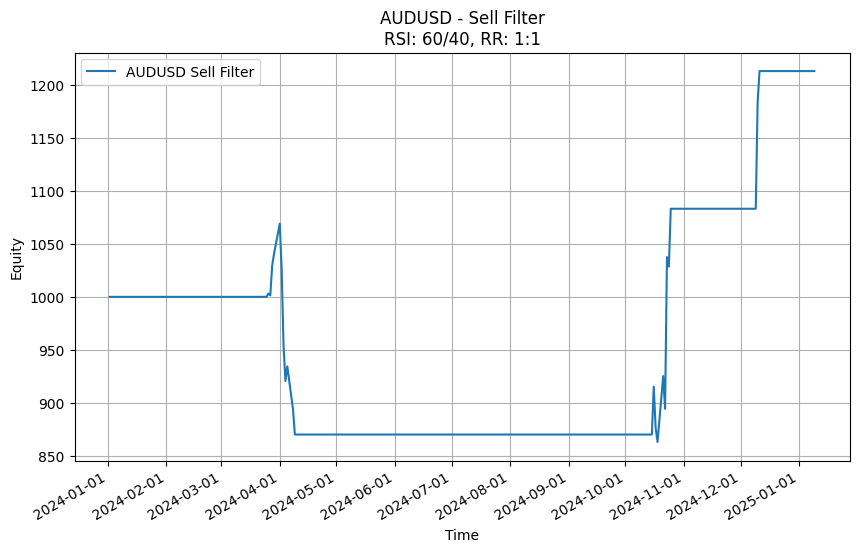

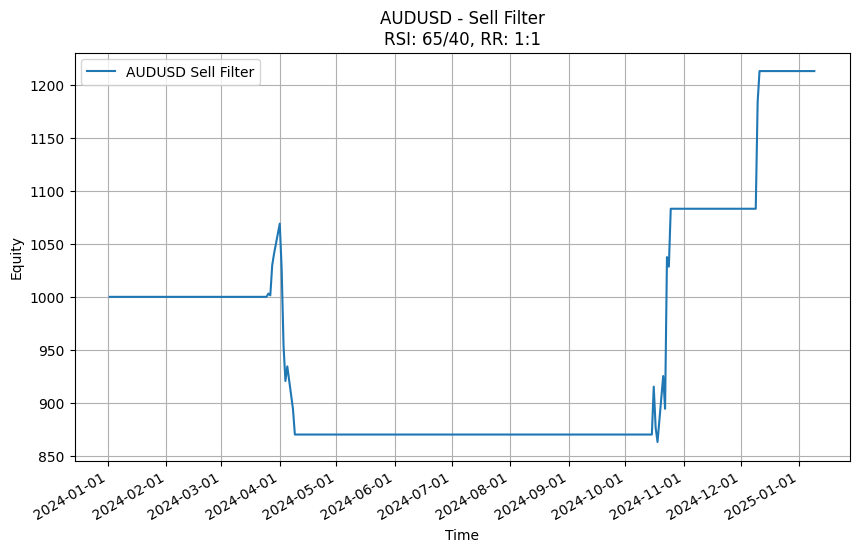

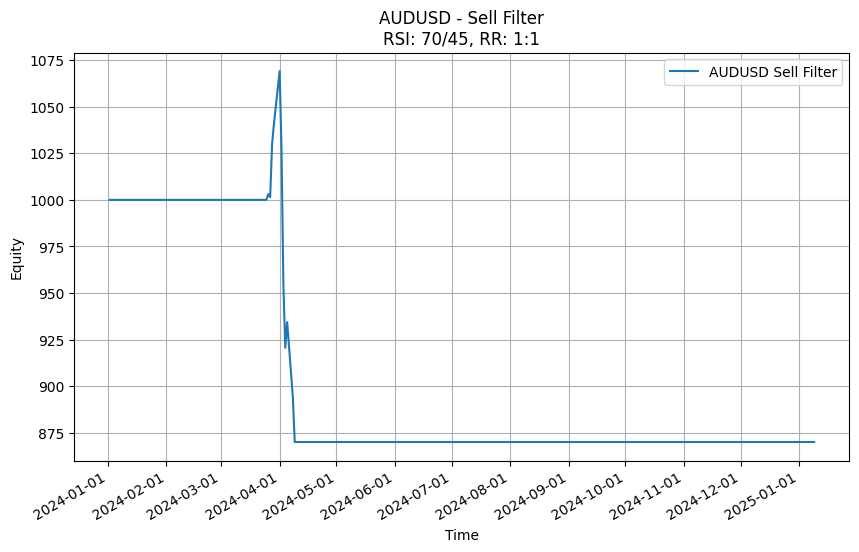

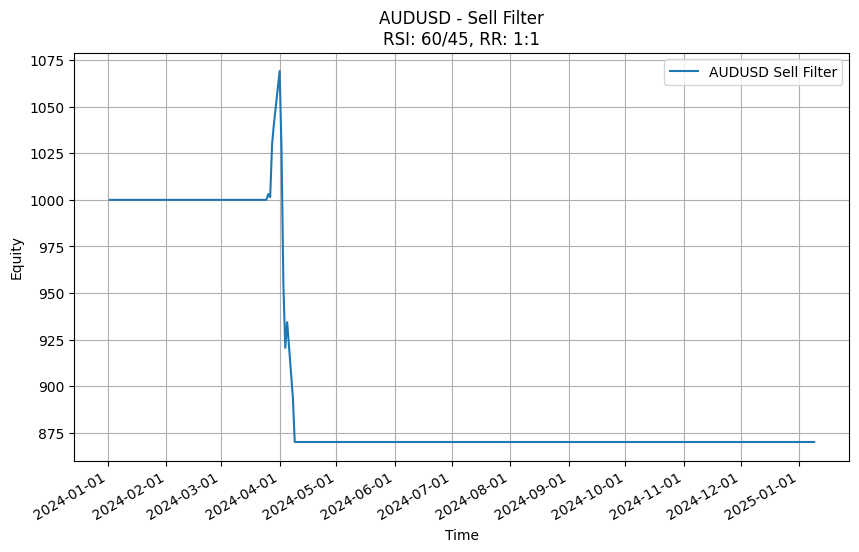

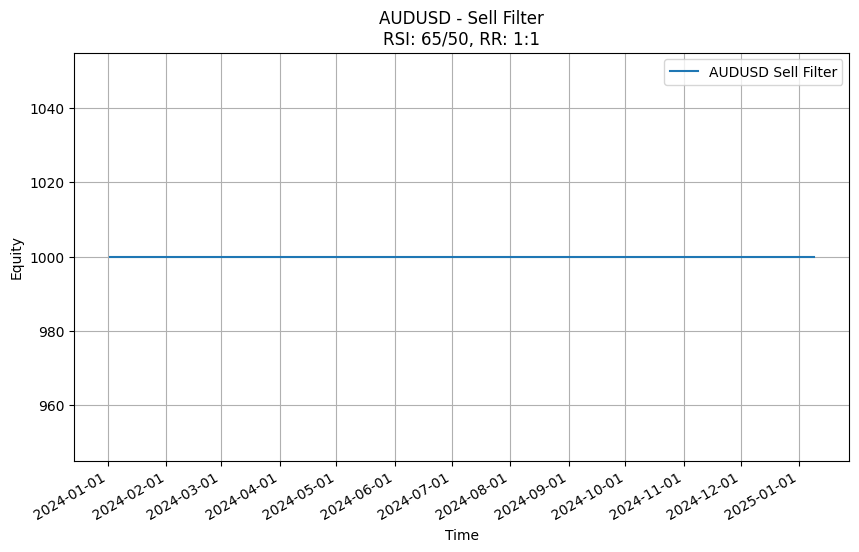

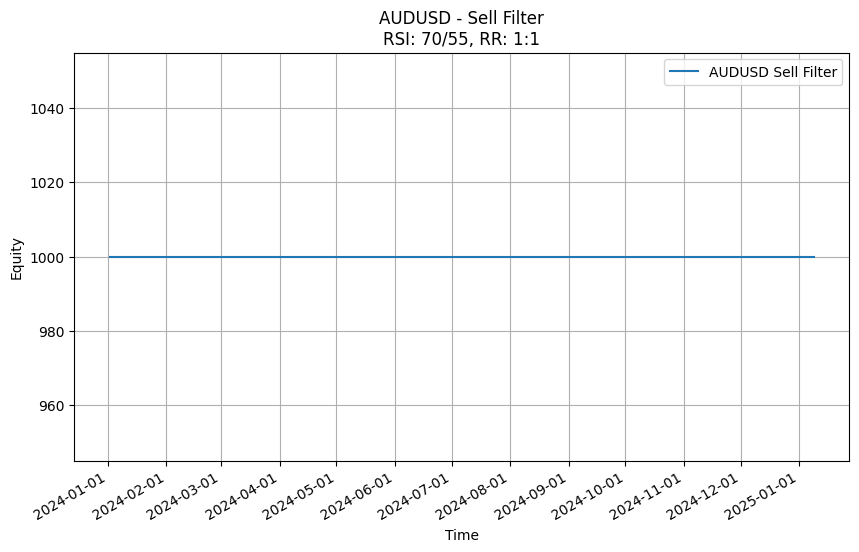

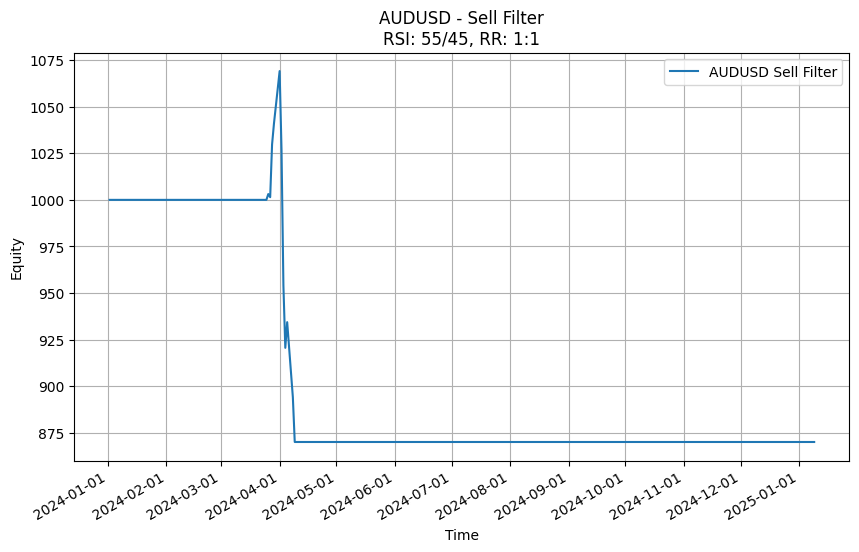

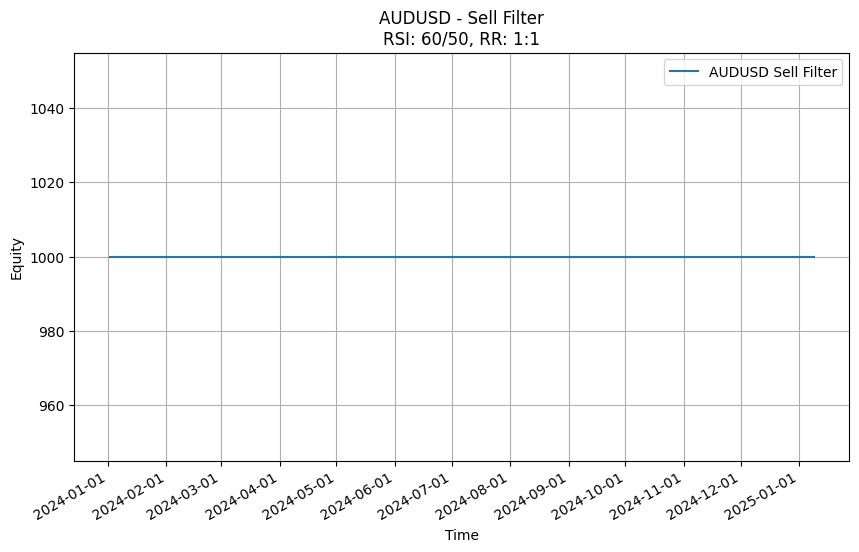

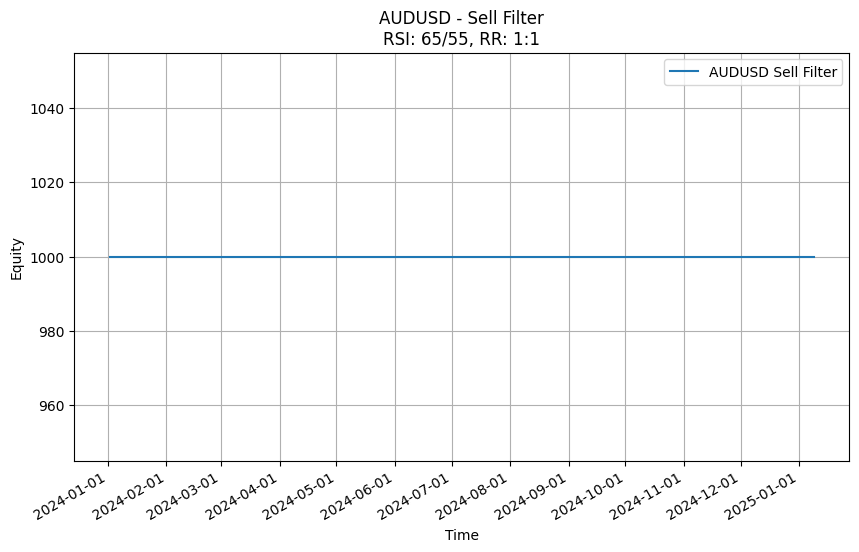

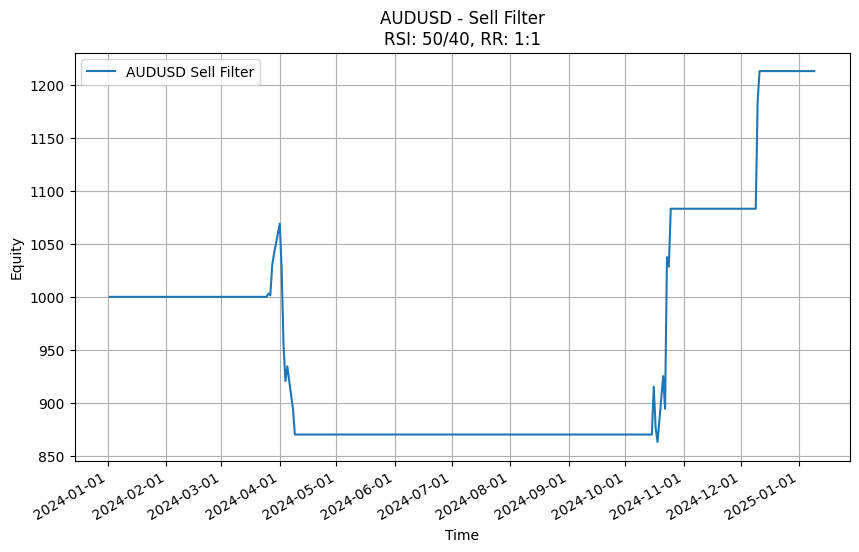

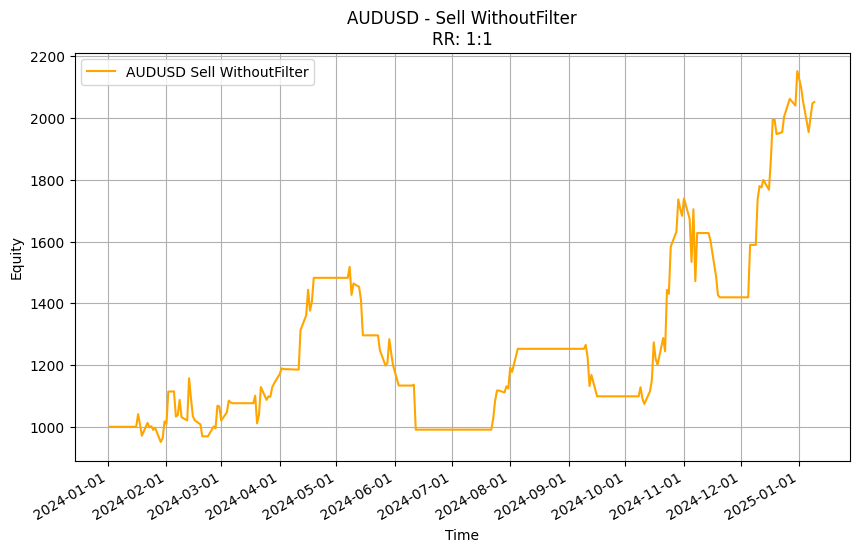

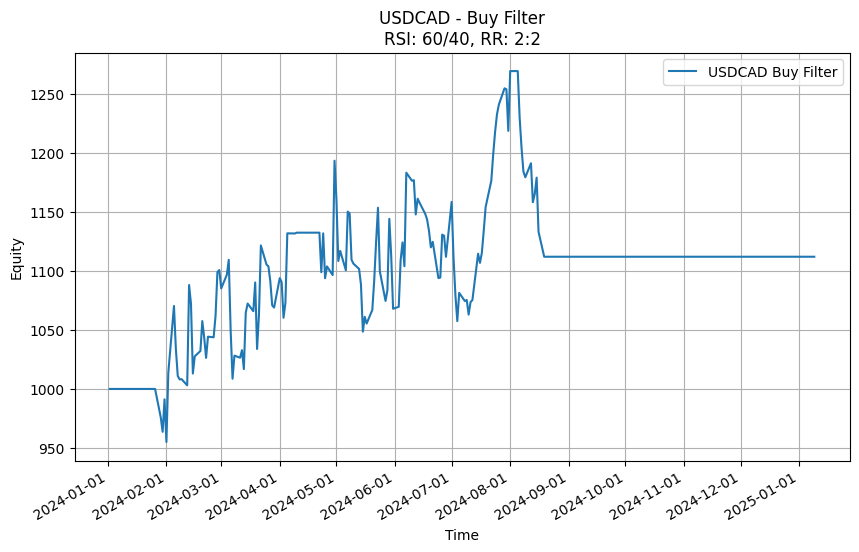

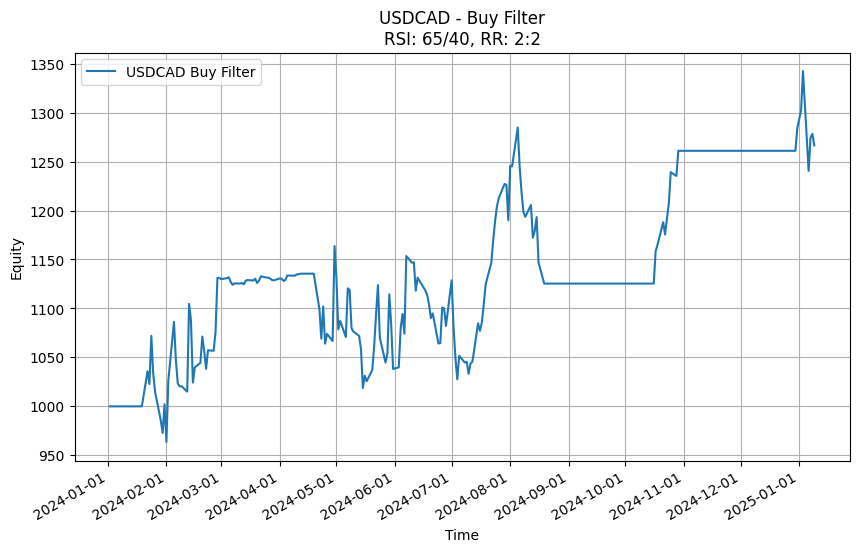

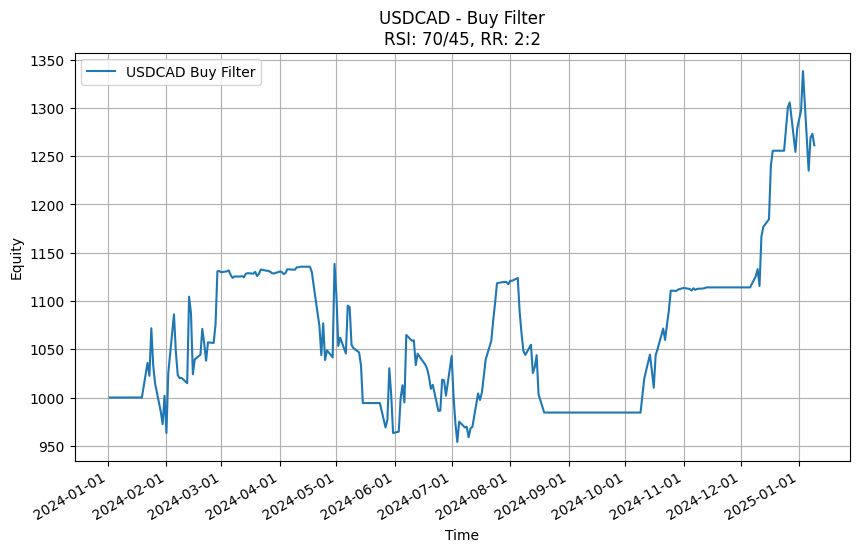

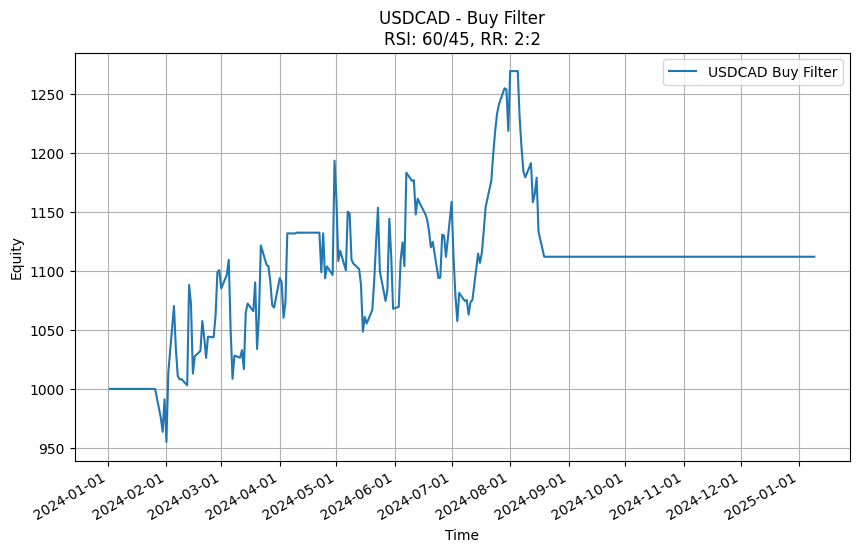

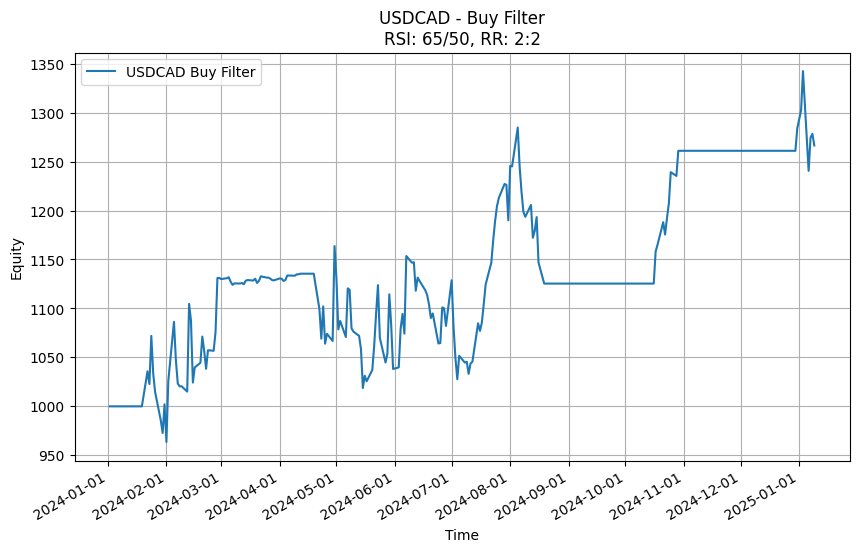

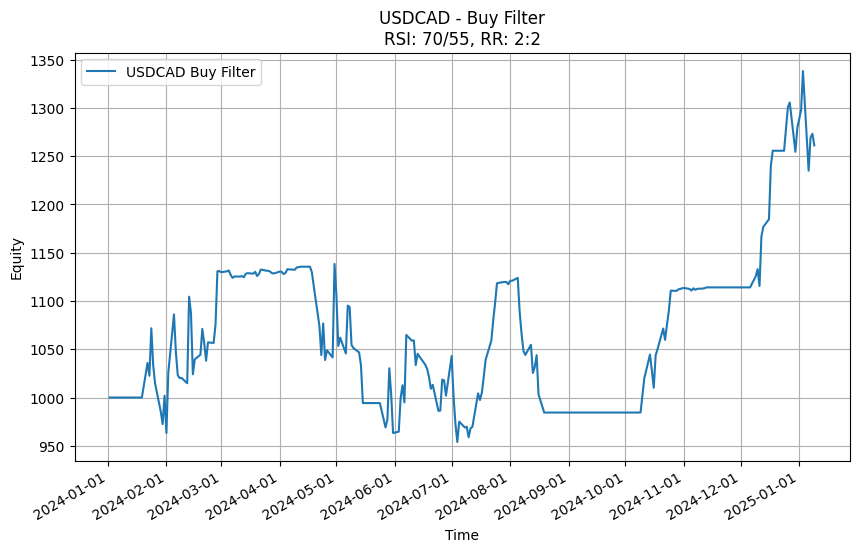

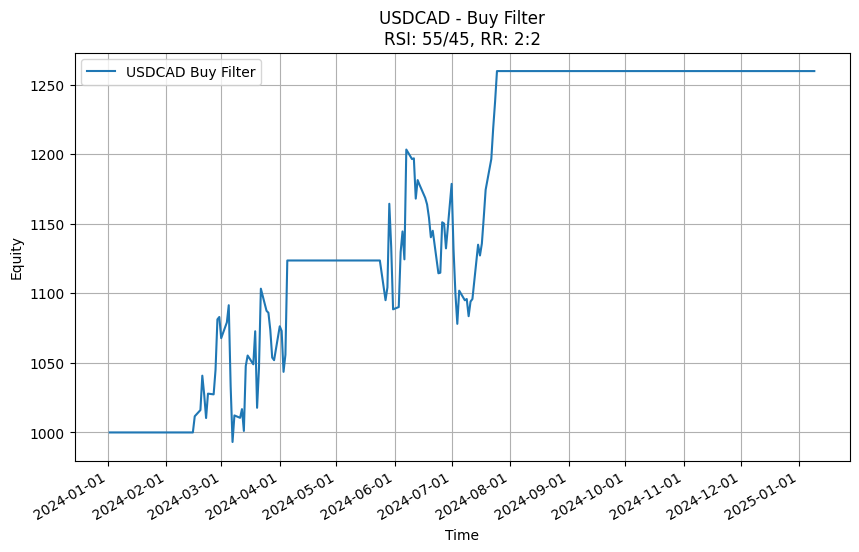

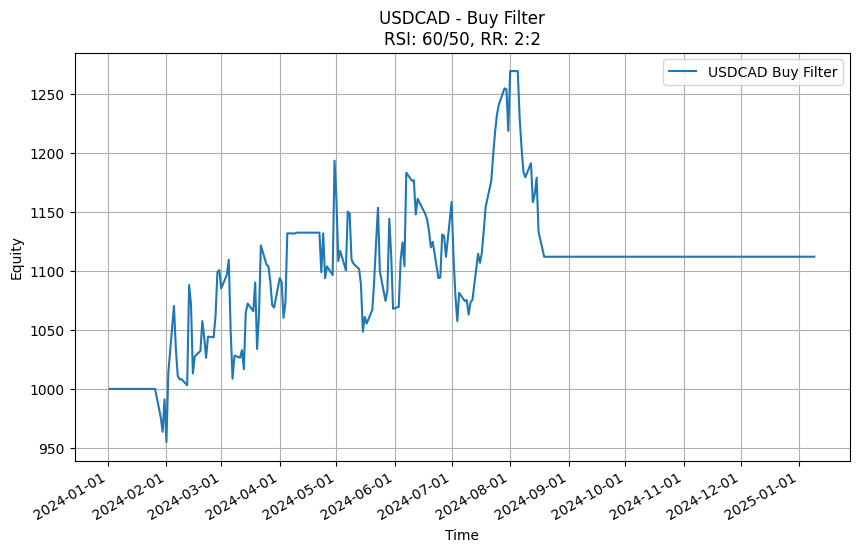

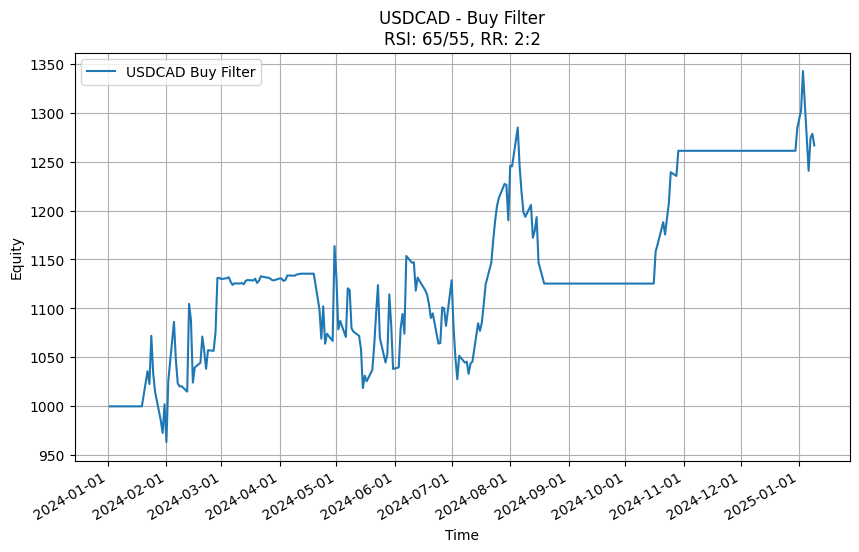

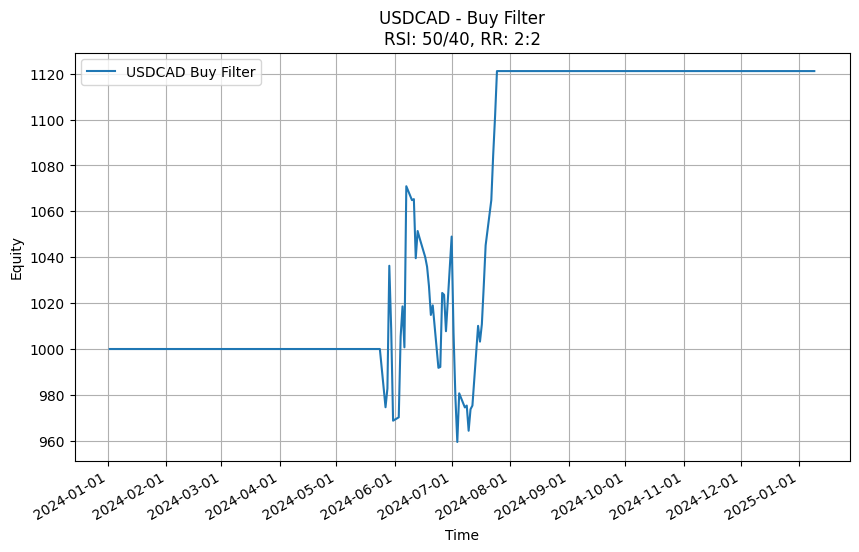

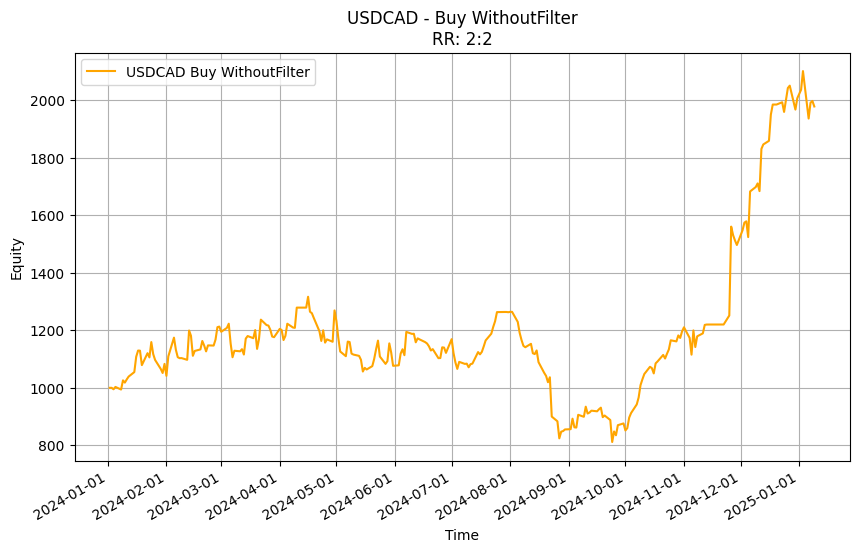


Backtest Summary:

  Pair Signal      Approach RSI (Buy/Sell) Risk/Reward  Final Equity  Return (%)  Max Drawdown (%)  Profit Factor  Sharpe Ratio  Win Rate (%)  Total Trades Avg Trade Duration                                   Equity Curve Image
EURUSD    Buy        Filter          60/40         1:1   1209.935332   20.993533        -14.628853       2.064120      0.554895     70.000000            10             2 days  plots/EURUSD\EURUSD_Buy_Filter_RSI_60_40_RR_1_1.png
EURUSD    Buy        Filter          65/40         1:1   1070.547313    7.054731        -25.732457       1.173861      0.143527     55.555556            18             3 days  plots/EURUSD\EURUSD_Buy_Filter_RSI_65_40_RR_1_1.png
EURUSD    Buy        Filter          70/45         1:1   1151.391873   15.139187        -19.328250       1.224322      0.278533     56.521739            23             2 days  plots/EURUSD\EURUSD_Buy_Filter_RSI_70_45_RR_1_1.png
EURUSD    Buy        Filter          60/45         1:1   1209.935332

In [ ]:



import sys
import os
import logging
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import pytz

import MetaTrader5 as mt5
from backtesting import Backtest, Strategy
from ta.momentum import RSIIndicator

# Logging configuration
logging.basicConfig(
    filename='backtest.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

def init_mt5_connection(login, password, server):
    if not mt5.initialize(login=login, password=password, server=server):
        logging.error(f"initialize() failed, error code = {mt5.last_error()}")
        sys.exit("MT5 initialization failed.")
    logging.info("Connected to MetaTrader 5")
    print("Connected to MetaTrader 5")

def fetch_ohlc_data(symbol, timeframe, start_date, end_date):
    data = mt5.copy_rates_range(symbol, timeframe, start_date, end_date)
    if data is None or len(data) == 0:
        logging.error(f"Failed to fetch data for {symbol}")
        return None
    df = pd.DataFrame(data)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.rename(
        columns={
            'open': 'Open',
            'high': 'High',
            'low': 'Low',
            'close': 'Close',
            'tick_volume': 'Volume'
        },
        inplace=True
    )
    return df[['time', 'Open', 'High', 'Low', 'Close', 'Volume']]

def add_technical_indicators(ohlc_data):
    ohlc_data['rsi'] = RSIIndicator(ohlc_data['Close'], window=14).rsi()
    ohlc_data['short_ma'] = ohlc_data['Close'].ewm(span=10, adjust=False).mean()
    ohlc_data['long_ma'] = ohlc_data['Close'].ewm(span=30, adjust=False).mean()
    short_ema = ohlc_data['Close'].ewm(span=12, adjust=False).mean()
    long_ema = ohlc_data['Close'].ewm(span=26, adjust=False).mean()
    ohlc_data['macd'] = short_ema - long_ema
    ohlc_data['macd_signal'] = ohlc_data['macd'].ewm(span=9, adjust=False).mean()
    return ohlc_data

def load_and_align_data(ohlc_data, prediction_file):
    try:
        pred_df = pd.read_csv(prediction_file, parse_dates=['time'])
        if 'prediction' not in pred_df.columns:
            logging.error(f"'prediction' column not found in {prediction_file}")
            return None
    except Exception as e:
        logging.error(f"Error loading prediction file {prediction_file}: {e}")
        return None

    merged = pd.merge(
        ohlc_data,
        pred_df[['time', 'prediction']],
        on='time',
        how='left'
    )
    merged['prediction'] = merged['prediction'].fillna(0)
    return merged

def calculate_prices(entry_price, risk_reward_ratio, mean_candle_size, trade_type):
    risk_part, reward_part = map(int, risk_reward_ratio.split(':'))
    risk_amount = mean_candle_size * risk_part
    reward_amount = mean_candle_size * reward_part

    if trade_type == "Buy":
        sl_price = entry_price - risk_amount
        tp_price = entry_price + reward_amount
    else:  # "Sell"
        sl_price = entry_price + risk_amount
        tp_price = entry_price - reward_amount

    return sl_price, tp_price

class FilterStrategy(Strategy):
    pair_name = None
    signal_type = None
    rsi_buy = 60
    rsi_sell = 40
    risk_reward_ratio = "1:1"        # e.g., "1:2"
    mean_candle_size = 0.005         # e.g., 0.005
    volume_threshold = 1000

    def init(self):
        pass

    def next(self):
        entry_price = self.data.Close[-1]
        buy_cond = (
            (self.data.rsi[-1] < self.rsi_buy) &
            (self.data.short_ma[-1] > self.data.long_ma[-1]) &
            (self.data.macd[-1] > self.data.macd_signal[-1]) &
            (self.data.Volume[-1] > self.volume_threshold)
        )
        sell_cond = (
            (self.data.rsi[-1] > self.rsi_sell) &
            (self.data.short_ma[-1] < self.data.long_ma[-1]) &
            (self.data.macd[-1] < self.data.macd_signal[-1]) &
            (self.data.Volume[-1] > self.volume_threshold)
        )

        if self.signal_type == 'Buy':
            if self.data.prediction[-2] == 1 and buy_cond:
                sl_price, tp_price = calculate_prices(
                    entry_price, self.risk_reward_ratio, 
                    self.mean_candle_size, "Buy"
                )
                self.buy(sl=sl_price, tp=tp_price)
        else: # 'Sell'
            if self.data.prediction[-1] == 1 and sell_cond:
                sl_price, tp_price = calculate_prices(
                    entry_price, self.risk_reward_ratio, 
                    self.mean_candle_size, "Sell"
                )
                self.sell(sl=sl_price, tp=tp_price)

class WithoutFilterStrategy(Strategy):
    pair_name = None
    signal_type = None
    risk_reward_ratio = "1:1"
    mean_candle_size = 0.005

    def init(self):
        pass

    def next(self):
        entry_price = self.data.Close[-1]
        if self.signal_type == 'Buy':
            if self.data.prediction[-1] == 1:
                sl_price, tp_price = calculate_prices(
                    entry_price, self.risk_reward_ratio, 
                    self.mean_candle_size, "Buy"
                )
                self.buy(sl=sl_price, tp=tp_price)
        else:  # 'Sell'
            if self.data.prediction[-1] == 1:
                sl_price, tp_price = calculate_prices(
                    entry_price, self.risk_reward_ratio, 
                    self.mean_candle_size, "Sell"
                )
                self.sell(sl=sl_price, tp=tp_price)

def run_filter_variations(
    ohlc_data, pair_name, signal_type, margin, risk_reward_ratio, 
    mean_candle_size, rsi_combos, results_summary
):
    for (rsi_buy, rsi_sell) in rsi_combos:
        FilterStrategy.pair_name = pair_name
        FilterStrategy.signal_type = signal_type
        FilterStrategy.rsi_buy = rsi_buy
        FilterStrategy.rsi_sell = rsi_sell
        FilterStrategy.risk_reward_ratio = risk_reward_ratio
        FilterStrategy.mean_candle_size = mean_candle_size

        bt = Backtest(
            ohlc_data.set_index('time'),
            FilterStrategy,
            cash=1000,
            commission=0.0003,
            margin=margin
        )
        stats = bt.run()
        # Access the equity curve
        eq_curve = stats['_equity_curve'].copy()

        pair_folder = f"plots/{pair_name}"
        os.makedirs(pair_folder, exist_ok=True)

        plt.figure(figsize=(10, 6))
        plt.plot(eq_curve.index, eq_curve['Equity'], label=f"{pair_name} {signal_type} Filter")
        plt.title(f"{pair_name} - {signal_type} Filter\nRSI: {rsi_buy}/{rsi_sell}, RR: {risk_reward_ratio}")
        plt.xlabel("Time")
        plt.ylabel("Equity")
        plt.legend()
        plt.grid(True)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gcf().autofmt_xdate()  # Rotate date labels
        plot_filename = os.path.join(
            pair_folder,
           f"{pair_name}_{signal_type}_Filter_RSI_{rsi_buy}_{rsi_sell}_RR_{risk_reward_ratio.replace(':','_')}.png")
        plt.savefig(plot_filename)
        plt.show()

        results_summary.append({
            "Pair": pair_name,
            "Signal": signal_type,
            "Approach": "Filter",
            "RSI (Buy/Sell)": f"{rsi_buy}/{rsi_sell}",
            "Risk/Reward": risk_reward_ratio,
            "Final Equity": stats['Equity Final [$]'],
            "Return (%)": stats['Return [%]'],
            "Max Drawdown (%)": stats['Max. Drawdown [%]'],
            "Profit Factor": stats['Profit Factor'],
            "Sharpe Ratio": stats['Sharpe Ratio'],
            "Win Rate (%)": stats['Win Rate [%]'],
            "Total Trades": stats['# Trades'],
            "Avg Trade Duration": stats['Avg. Trade Duration'],
            "Equity Curve Image": plot_filename,
        })

def run_without_filter_once(
    ohlc_data, pair_name, signal_type, margin, 
    risk_reward_ratio, mean_candle_size, results_summary
):
    WithoutFilterStrategy.pair_name = pair_name
    WithoutFilterStrategy.signal_type = signal_type
    WithoutFilterStrategy.risk_reward_ratio = risk_reward_ratio
    WithoutFilterStrategy.mean_candle_size = mean_candle_size

    bt = Backtest(
        ohlc_data.set_index('time'),
        WithoutFilterStrategy,
        cash=1000,
        commission=0.0003,
        margin=margin
    )
    stats = bt.run()
    # Access the equity curve
    eq_curve = stats['_equity_curve'].copy()

    pair_folder = f"plots/{pair_name}"
    os.makedirs(pair_folder, exist_ok=True)

    plt.figure(figsize=(10, 6))
    plt.plot(eq_curve.index, eq_curve['Equity'], label=f"{pair_name} {signal_type} WithoutFilter", color='orange')
    plt.title(f"{pair_name} - {signal_type} WithoutFilter\nRR: {risk_reward_ratio}")
    plt.xlabel("Time")
    plt.ylabel("Equity")
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()  # Rotate date labels
    plot_filename = os.path.join(
        pair_folder,
        f"{pair_name}_{signal_type}_WithoutFilter_RR_{risk_reward_ratio.replace(':','_')}.png")
    plt.savefig(plot_filename)
    plt.show()

    results_summary.append({
        "Pair": pair_name,
        "Signal": signal_type,
        "Approach": "WithoutFilter",
        "RSI (Buy/Sell)": "N/A",
        "Risk/Reward": risk_reward_ratio,
        "Final Equity": stats['Equity Final [$]'],
        "Return (%)": stats['Return [%]'],
        "Max Drawdown (%)": stats['Max. Drawdown [%]'],
        "Profit Factor": stats['Profit Factor'],
        "Sharpe Ratio": stats['Sharpe Ratio'],
        "Win Rate (%)": stats['Win Rate [%]'],
        "Total Trades": stats['# Trades'],
        "Avg Trade Duration": stats['Avg. Trade Duration'],
        "Equity Curve Image": plot_filename,
    })

def summarize_results(results_summary):
    if not results_summary:
        print("No results to summarize.")
        return
    df_summary = pd.DataFrame(results_summary)
    print("\nBacktest Summary:\n")
    print(df_summary.to_string(index=False))
    df_summary.to_csv("backtest_results_summary.csv", index=False)
    print("\nResults summary saved to backtest_results_summary.csv")

def main():
    config = {
        'login': 51988090,
        'password': '1fMdV52$74EOcw',
        'server': 'ICMarketsEU-Demo',

        # Each pair has mean_candle_size, and risk-reward ratio in "X:Y" format
        'EURUSD': {
            'symbol': 'EURUSD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.005,
            'buy_prediction_file': 'pred_EURUSD_Buy.csv',
            #'sell_prediction_file': 'testfiles\pred_AUDUSD_Buy.csv',
            'buy_risk_reward_ratio': "1:1",
            'sell_risk_reward_ratio': "1:1",
            'rsi_combos': [(60, 40),(65, 40),(70, 45),(60, 45),(65, 50),(70, 55),(55, 45),(60, 50),(65, 55),(50, 40)],
            'margin': 0.05
        },
        'GBPUSD': {
            'symbol': 'GBPUSD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.01,
            'buy_prediction_file': 'pred_GBPUSD_Buy.csv',
            'sell_prediction_file': 'pred_GBPUSD_Sell.csv',
            'buy_risk_reward_ratio': "1:1",
            'sell_risk_reward_ratio': "1:1",
            'rsi_combos': [(60, 40),(65, 40),(70, 45),(60, 45),(65, 50),(70, 55),(55, 45),(60, 50),(65, 55),(50, 40)],
            'margin': 0.1
        },
        'AUDUSD': {
            'symbol': 'AUDUSD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.008,
            'buy_prediction_file': 'pred_AUDUSD_Buy.csv',
            'sell_prediction_file': 'pred_AUDUSD_Sell.csv',
            'buy_risk_reward_ratio': "1:1",
            'sell_risk_reward_ratio': "1:1",
            'rsi_combos': [(60, 40),(65, 40),(70, 45),(60, 45),(65, 50),(70, 55),(55, 45),(60, 50),(65, 55),(50, 40)],
            'margin': 0.1
        },
        'USDCAD': {
            'symbol': 'USDCAD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.0085,
            'buy_prediction_file': 'pred_USDCAD_Buy.csv',
            'sell_prediction_file': 'pred_USDCAD_Sell.csv',
            'buy_risk_reward_ratio': "2:2",
            'sell_risk_reward_ratio': "2:3",
            'rsi_combos': [(60, 40),(65, 40),(70, 45),(60, 45),(65, 50),(70, 55),(55, 45),(60, 50),(65, 55),(50, 40)],
            'margin': 0.1
        } 
    }

    init_mt5_connection(config['login'], config['password'], config['server'])
    utc_from = datetime(2024, 1, 1, tzinfo=pytz.utc)
    utc_to = datetime(2025, 1, 9, tzinfo=pytz.utc)

    results_summary = []

    for pair_name, pair_cfg in config.items():
        if pair_name in ['login', 'password', 'server']:
            continue

        df_ohlc = fetch_ohlc_data(
            pair_cfg['symbol'], pair_cfg['timeframe'], utc_from, utc_to
        )
        if df_ohlc is None or df_ohlc.empty:
            logging.warning(f"No data for {pair_name}, skipping.")
            continue

        df_ohlc = add_technical_indicators(df_ohlc)

        # Optional: Plot RSI & MAs
        pair_folder = f"plots/{pair_name}"
        os.makedirs(pair_folder, exist_ok=True)

       #plt.figure(figsize=(10, 5))
       # plt.plot(df_ohlc['time'], df_ohlc['rsi'], label='RSI')
       # plt.title(f'RSI for {pair_name}')
       # plt.grid(True)
        #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        #plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        #plt.legend()
        #rsi_plot_file = os.path.join(pair_folder, f"{pair_name}_RSI.png")
        #plt.savefig(rsi_plot_file)
        #plt.show()

        #plt.figure(figsize=(10, 5))
        #plt.plot(df_ohlc['time'], df_ohlc['short_ma'], label='Short MA', color='blue')
        #plt.plot(df_ohlc['time'], df_ohlc['long_ma'], label='Long MA', color='orange')
        #plt.title(f'Moving Averages for {pair_name}')
        #plt.grid(True)
        #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        #plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        #plt.legend()
        #ma_plot_file = os.path.join(pair_folder, f"{pair_name}_MA.png")
        #plt.savefig(ma_plot_file)
        #plt.show()

        # For each signal type

        for signal_type in ['Buy', 'Sell']:
            pred_file_key = f"{signal_type.lower()}_prediction_file"
            rr_key = f"{signal_type.lower()}_risk_reward_ratio"
            if pred_file_key not in pair_cfg or rr_key not in pair_cfg:
                logging.warning(f"No config for {pair_name} {signal_type}")
                continue

            pred_file = pair_cfg[pred_file_key]
            df_pred = load_and_align_data(df_ohlc, pred_file)
            if df_pred is None or df_pred.empty:
                logging.warning(f"No predictions for {pair_name} {signal_type}, skipping.")
                continue

            risk_reward_ratio = pair_cfg[rr_key]
            mean_candle_size = pair_cfg.get('mean_candle_size', 0.005)
            rsi_combos = pair_cfg.get('rsi_combos', [(60, 40)])
            margin = pair_cfg['margin']

            # 1) Filter approach (multiple RSI combos)
            run_filter_variations(
                df_pred,
                pair_name,
                signal_type,
                margin,
                risk_reward_ratio,
                mean_candle_size,
                rsi_combos,
                results_summary
            )

            # 2) WithoutFilter approach (once)
            run_without_filter_once(
                df_pred,
                pair_name,
                signal_type,
                margin,
                risk_reward_ratio,
                mean_candle_size,
                results_summary
            )

    summarize_results(results_summary)
    mt5.shutdown()

if __name__ == "__main__":
    main()


In [1]:
import sys
import os
import logging
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import pytz

import MetaTrader5 as mt5
from backtesting import Backtest, Strategy
from ta.momentum import RSIIndicator

# Logging configuration
logging.basicConfig(
    filename='backtest.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

def init_mt5_connection(login, password, server):
    if not mt5.initialize(login=login, password=password, server=server):
        logging.error(f"initialize() failed, error code = {mt5.last_error()}")
        sys.exit("MT5 initialization failed.")
    logging.info("Connected to MetaTrader 5")
    print("Connected to MetaTrader 5")

def fetch_ohlc_data(symbol, timeframe, start_date, end_date):
    data = mt5.copy_rates_range(symbol, timeframe, start_date, end_date)
    if data is None or len(data) == 0:
        logging.error(f"Failed to fetch data for {symbol}")
        return None
    df = pd.DataFrame(data)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.rename(
        columns={
            'open': 'Open',
            'high': 'High',
            'low': 'Low',
            'close': 'Close',
            'tick_volume': 'Volume'
        },
        inplace=True
    )
    return df[['time', 'Open', 'High', 'Low', 'Close', 'Volume']]

def add_technical_indicators(ohlc_data, ema_short_span=10, ema_long_span=30, macd_short_span=12, macd_long_span=26, macd_signal_span=9):
    ohlc_data['rsi'] = RSIIndicator(ohlc_data['Close'], window=14).rsi()
    ohlc_data['short_ma'] = ohlc_data['Close'].ewm(span=ema_short_span, adjust=False).mean()
    ohlc_data['long_ma'] = ohlc_data['Close'].ewm(span=ema_long_span, adjust=False).mean()
    short_ema = ohlc_data['Close'].ewm(span=macd_short_span, adjust=False).mean()
    long_ema = ohlc_data['Close'].ewm(span=macd_long_span, adjust=False).mean()
    ohlc_data['macd'] = short_ema - long_ema
    ohlc_data['macd_signal'] = ohlc_data['macd'].ewm(span=macd_signal_span, adjust=False).mean()
    return ohlc_data

def load_and_align_data(ohlc_data, prediction_file):
    try:
        pred_df = pd.read_csv(prediction_file, parse_dates=['time'])
        if 'prediction' not in pred_df.columns:
            logging.error(f"'prediction' column not found in {prediction_file}")
            return None
    except Exception as e:
        logging.error(f"Error loading prediction file {prediction_file}: {e}")
        return None

    merged = pd.merge(
        ohlc_data,
        pred_df[['time', 'prediction']],
        on='time',
        how='left'
    )
    merged['prediction'] = merged['prediction'].fillna(0)
    return merged

def calculate_prices(entry_price, risk_reward_ratio, mean_candle_size, trade_type):
    risk_part, reward_part = map(int, risk_reward_ratio.split(':'))
    risk_amount = mean_candle_size * risk_part
    reward_amount = mean_candle_size * reward_part

    if trade_type == "Buy":
        sl_price = entry_price - risk_amount
        tp_price = entry_price + reward_amount
    else:  # "Sell"
        sl_price = entry_price + risk_amount
        tp_price = entry_price - reward_amount

    return sl_price, tp_price

class FilterStrategy(Strategy):
    # Initialize default class variables
    pair_name = None
    signal_type = None
    rsi_buy = 60
    rsi_sell = 40
    risk_reward_ratio = "1:1"        # e.g., "1:2"
    mean_candle_size = 0.005         # e.g., 0.005
    volume_threshold = 1000
    ema_short_span = 10
    ema_long_span = 30
    macd_short_span = 12
    macd_long_span = 26
    macd_signal_span = 9

    def init(self):
        pass

    def next(self):
        entry_price = self.data.Close[-1]
        buy_cond = (
            (self.data.rsi[-1] < self.rsi_buy) &
            (self.data.short_ma[-1] > self.data.long_ma[-1]) &
            (self.data.macd[-1] > self.data.macd_signal[-1]) &
            (self.data.Volume[-1] > self.volume_threshold)
        )
        sell_cond = (
            (self.data.rsi[-1] > self.rsi_sell) &
            (self.data.short_ma[-1] < self.data.long_ma[-1]) &
            (self.data.macd[-1] < self.data.macd_signal[-1]) &
            (self.data.Volume[-1] > self.volume_threshold)
        )

        if self.signal_type == 'Buy':
            if self.data.prediction[-1] == 1 and buy_cond:
                sl_price, tp_price = calculate_prices(
                    entry_price, self.risk_reward_ratio, 
                    self.mean_candle_size, "Buy"
                )
                self.buy(sl=sl_price, tp=tp_price)
        else: # 'Sell'
            if self.data.prediction[-1] == 1 and sell_cond:
                sl_price, tp_price = calculate_prices(
                    entry_price, self.risk_reward_ratio, 
                    self.mean_candle_size, "Sell"
                )
                self.sell(sl=sl_price, tp=tp_price)

class WithoutFilterStrategy(Strategy):
    pair_name = None
    signal_type = None
    risk_reward_ratio = "1:1"
    mean_candle_size = 0.005

    def init(self):
        pass

    def next(self):
        entry_price = self.data.Close[-1]
        if self.signal_type == 'Buy':
            if self.data.prediction[-1] == 1:
                sl_price, tp_price = calculate_prices(
                    entry_price, self.risk_reward_ratio, 
                    self.mean_candle_size, "Buy"
                )
                self.buy(sl=sl_price, tp=tp_price)
        else:  # 'Sell'
            if self.data.prediction[-1] == 1:
                sl_price, tp_price = calculate_prices(
                    entry_price, self.risk_reward_ratio, 
                    self.mean_candle_size, "Sell"
                )
                self.sell(sl=sl_price, tp=tp_price)

def run_filter_variations(
    ohlc_data, pair_name, signal_type, margin, risk_reward_ratio, 
    mean_candle_size, parameter_combos, results_summary
):
    for params in parameter_combos:
        # Unpack parameters
        rsi_buy, rsi_sell = params['rsi']
        ema_short_span = params['ema_short_span']
        ema_long_span = params['ema_long_span']
        macd_short_span = params['macd_short_span']
        macd_long_span = params['macd_long_span']
        macd_signal_span = params['macd_signal_span']

        # Add technical indicators with current parameters
        df = add_technical_indicators(
            ohlc_data.copy(),
            ema_short_span=ema_short_span,
            ema_long_span=ema_long_span,
            macd_short_span=macd_short_span,
            macd_long_span=macd_long_span,
            macd_signal_span=macd_signal_span
        )

        FilterStrategy.pair_name = pair_name
        FilterStrategy.signal_type = signal_type
        FilterStrategy.rsi_buy = rsi_buy
        FilterStrategy.rsi_sell = rsi_sell
        FilterStrategy.risk_reward_ratio = risk_reward_ratio
        FilterStrategy.mean_candle_size = mean_candle_size
        FilterStrategy.ema_short_span = ema_short_span
        FilterStrategy.ema_long_span = ema_long_span
        FilterStrategy.macd_short_span = macd_short_span
        FilterStrategy.macd_long_span = macd_long_span
        FilterStrategy.macd_signal_span = macd_signal_span

        bt = Backtest(
            df.set_index('time'),
            FilterStrategy,
            cash=1000,
            commission=0.0003,
            margin=margin
        )
        stats = bt.run()
        # Access the equity curve
        eq_curve = stats['_equity_curve'].copy()

        pair_folder = f"plots/{pair_name}"
        os.makedirs(pair_folder, exist_ok=True)

        plt.figure(figsize=(10, 6))
        plt.plot(eq_curve.index, eq_curve['Equity'], label=f"{pair_name} {signal_type} Filter")
        plt.title(
            f"{pair_name} - {signal_type} Filter\nRSI: {rsi_buy}/{rsi_sell}, "
            f"EMA: {ema_short_span}/{ema_long_span}, MACD: {macd_short_span}/{macd_long_span}/{macd_signal_span}, "
            f"RR: {risk_reward_ratio}"
        )
        plt.xlabel("Time")
        plt.ylabel("Equity")
        plt.legend()
        plt.grid(True)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gcf().autofmt_xdate()  # Rotate date labels
        plot_filename = os.path.join(
            pair_folder,
            f"{pair_name}_{signal_type}_Filter_RSI_{rsi_buy}_{rsi_sell}_EMA_{ema_short_span}_{ema_long_span}_MACD_{macd_short_span}_{macd_long_span}_{macd_signal_span}_RR_{risk_reward_ratio.replace(':','_')}.png"
        )
        plt.savefig(plot_filename)
        plt.close()  # Use close to avoid displaying during batch runs

        results_summary.append({
            "Pair": pair_name,
            "Signal": signal_type,
            "Approach": "Filter",
            "RSI (Buy/Sell)": f"{rsi_buy}/{rsi_sell}",
            "EMA (Short/Long)": f"{ema_short_span}/{ema_long_span}",
            "MACD (Short/Long/Signal)": f"{macd_short_span}/{macd_long_span}/{macd_signal_span}",
            "Risk/Reward": risk_reward_ratio,
            "Final Equity": stats['Equity Final [$]'],
            "Return (%)": stats['Return [%]'],
            "Max Drawdown (%)": stats['Max. Drawdown [%]'],
            "Profit Factor": stats['Profit Factor'],
            "Sharpe Ratio": stats['Sharpe Ratio'],
            "Win Rate (%)": stats['Win Rate [%]'],
            "Total Trades": stats['# Trades'],
            "Avg Trade Duration": stats['Avg. Trade Duration'],
            "Equity Curve Image": plot_filename,
        })

def run_without_filter_once(
    ohlc_data, pair_name, signal_type, margin, 
    risk_reward_ratio, mean_candle_size, results_summary
):
    WithoutFilterStrategy.pair_name = pair_name
    WithoutFilterStrategy.signal_type = signal_type
    WithoutFilterStrategy.risk_reward_ratio = risk_reward_ratio
    WithoutFilterStrategy.mean_candle_size = mean_candle_size

    bt = Backtest(
        ohlc_data.set_index('time'),
        WithoutFilterStrategy,
        cash=1000,
        commission=0.0003,
        margin=margin
    )
    stats = bt.run()
    # Access the equity curve
    eq_curve = stats['_equity_curve'].copy()

    pair_folder = f"plots/{pair_name}"
    os.makedirs(pair_folder, exist_ok=True)

    plt.figure(figsize=(10, 6))
    plt.plot(eq_curve.index, eq_curve['Equity'], label=f"{pair_name} {signal_type} WithoutFilter", color='orange')
    plt.title(f"{pair_name} - {signal_type} WithoutFilter\nRR: {risk_reward_ratio}")
    plt.xlabel("Time")
    plt.ylabel("Equity")
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()  # Rotate date labels
    plot_filename = os.path.join(
        pair_folder,
        f"{pair_name}_{signal_type}_WithoutFilter_RR_{risk_reward_ratio.replace(':','_')}.png"
    )
    plt.savefig(plot_filename)
    plt.close()  # Use close to avoid displaying during batch runs

    results_summary.append({
        "Pair": pair_name,
        "Signal": signal_type,
        "Approach": "WithoutFilter",
        "RSI (Buy/Sell)": "N/A",
        "EMA (Short/Long)": "N/A",
        "MACD (Short/Long/Signal)": "N/A",
        "Risk/Reward": risk_reward_ratio,
        "Final Equity": stats['Equity Final [$]'],
        "Return (%)": stats['Return [%]'],
        "Max Drawdown (%)": stats['Max. Drawdown [%]'],
        "Profit Factor": stats['Profit Factor'],
        "Sharpe Ratio": stats['Sharpe Ratio'],
        "Win Rate (%)": stats['Win Rate [%]'],
        "Total Trades": stats['# Trades'],
        "Avg Trade Duration": stats['Avg. Trade Duration'],
        "Equity Curve Image": plot_filename,
    })

def summarize_results(results_summary):
    if not results_summary:
        print("No results to summarize.")
        return
    df_summary = pd.DataFrame(results_summary)
    print("\nBacktest Summary:\n")
    print(df_summary.to_string(index=False))
    df_summary.to_csv("backtest_results_summary1.csv", index=False)
    print("\nResults summary saved to backtest_results_summary.csv")

def main():
    config = {
        'login': 51988090,
        'password': '1fMdV52$74EOcw',
        'server': 'ICMarketsEU-Demo',

        # Each pair has mean_candle_size, risk-reward ratio, and parameter ranges
        'EURUSD': {
            'symbol': 'EURUSD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.009,
            'buy_prediction_file': 'pred_EURUSD_Buy copy.csv',
            'sell_prediction_file': 'pred_EURUSD_Sell.csv',
            'buy_risk_reward_ratio': "1:1",
            'sell_risk_reward_ratio': "1:1",
            'parameter_combos': [
                # Define each parameter set as a dictionary
                {'rsi': (60, 40), 'ema_short_span': 10, 'ema_long_span': 30, 'macd_short_span': 12, 'macd_long_span': 26, 'macd_signal_span': 9},
                {'rsi': (65, 40), 'ema_short_span': 12, 'ema_long_span': 28, 'macd_short_span': 13, 'macd_long_span': 25, 'macd_signal_span': 9},
                {'rsi': (70, 45), 'ema_short_span': 14, 'ema_long_span': 32, 'macd_short_span': 14, 'macd_long_span': 24, 'macd_signal_span': 10},
                {'rsi': (55, 35), 'ema_short_span': 8,  'ema_long_span': 25, 'macd_short_span': 11, 'macd_long_span': 24, 'macd_signal_span': 8},
                {'rsi': (60, 40), 'ema_short_span': 11, 'ema_long_span': 29, 'macd_short_span': 12, 'macd_long_span': 27, 'macd_signal_span': 10},
                {'rsi': (65, 45), 'ema_short_span': 13, 'ema_long_span': 31, 'macd_short_span': 14, 'macd_long_span': 28, 'macd_signal_span': 11},
                {'rsi': (70, 50), 'ema_short_span': 15, 'ema_long_span': 35, 'macd_short_span': 15, 'macd_long_span': 30, 'macd_signal_span': 12},
                {'rsi': (58, 38), 'ema_short_span': 9,  'ema_long_span': 26, 'macd_short_span': 12, 'macd_long_span': 25, 'macd_signal_span': 9},
                {'rsi': (63, 43), 'ema_short_span': 12, 'ema_long_span': 30, 'macd_short_span': 13, 'macd_long_span': 27, 'macd_signal_span': 10},
                {'rsi': (68, 48), 'ema_short_span': 14, 'ema_long_span': 34, 'macd_short_span': 14, 'macd_long_span': 28, 'macd_signal_span': 11},
                # Add more combinations as needed
            ],
            'margin': 0.05
        },
        'GBPUSD': {
            'symbol': 'GBPUSD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.01,
            'buy_prediction_file': 'pred_GBPUSD_Buy copy.csv',
            'sell_prediction_file': 'pred_GBPUSD_Sell copy.csv',
            'buy_risk_reward_ratio': "1:1",
            'sell_risk_reward_ratio': "1:1",
            'parameter_combos': [
                {'rsi': (60, 40), 'ema_short_span': 10, 'ema_long_span': 30, 'macd_short_span': 12, 'macd_long_span': 26, 'macd_signal_span': 9},
                {'rsi': (65, 40), 'ema_short_span': 12, 'ema_long_span': 28, 'macd_short_span': 13, 'macd_long_span': 25, 'macd_signal_span': 9},
                {'rsi': (70, 45), 'ema_short_span': 14, 'ema_long_span': 32, 'macd_short_span': 14, 'macd_long_span': 24, 'macd_signal_span': 10},
                {'rsi': (55, 35), 'ema_short_span': 8,  'ema_long_span': 25, 'macd_short_span': 11, 'macd_long_span': 24, 'macd_signal_span': 8},
                {'rsi': (60, 40), 'ema_short_span': 11, 'ema_long_span': 29, 'macd_short_span': 12, 'macd_long_span': 27, 'macd_signal_span': 10},
                {'rsi': (65, 45), 'ema_short_span': 13, 'ema_long_span': 31, 'macd_short_span': 14, 'macd_long_span': 28, 'macd_signal_span': 11},
                {'rsi': (70, 50), 'ema_short_span': 15, 'ema_long_span': 35, 'macd_short_span': 15, 'macd_long_span': 30, 'macd_signal_span': 12},
                {'rsi': (58, 38), 'ema_short_span': 9,  'ema_long_span': 26, 'macd_short_span': 12, 'macd_long_span': 25, 'macd_signal_span': 9},
                {'rsi': (63, 43), 'ema_short_span': 12, 'ema_long_span': 30, 'macd_short_span': 13, 'macd_long_span': 27, 'macd_signal_span': 10},
                {'rsi': (68, 48), 'ema_short_span': 14, 'ema_long_span': 34, 'macd_short_span': 14, 'macd_long_span': 28, 'macd_signal_span': 11},
                # Add more combinations as needed
            ],
            'margin': 0.1
        },
        'AUDUSD': {
            'symbol': 'AUDUSD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.008,
            'buy_prediction_file': 'pred_AUDUSD_Buy copy.csv',
            'sell_prediction_file': 'pred_AUDUSD_Sell copy.csv',
            'buy_risk_reward_ratio': "1:1",
            'sell_risk_reward_ratio': "1:1",
            'parameter_combos': [
                {'rsi': (60, 40), 'ema_short_span': 10, 'ema_long_span': 30, 'macd_short_span': 12, 'macd_long_span': 26, 'macd_signal_span': 9},
                {'rsi': (65, 40), 'ema_short_span': 12, 'ema_long_span': 28, 'macd_short_span': 13, 'macd_long_span': 25, 'macd_signal_span': 9},
                {'rsi': (70, 45), 'ema_short_span': 14, 'ema_long_span': 32, 'macd_short_span': 14, 'macd_long_span': 24, 'macd_signal_span': 10},
                {'rsi': (55, 35), 'ema_short_span': 8,  'ema_long_span': 25, 'macd_short_span': 11, 'macd_long_span': 24, 'macd_signal_span': 8},
                {'rsi': (60, 40), 'ema_short_span': 11, 'ema_long_span': 29, 'macd_short_span': 12, 'macd_long_span': 27, 'macd_signal_span': 10},
                {'rsi': (65, 45), 'ema_short_span': 13, 'ema_long_span': 31, 'macd_short_span': 14, 'macd_long_span': 28, 'macd_signal_span': 11},
                {'rsi': (70, 50), 'ema_short_span': 15, 'ema_long_span': 35, 'macd_short_span': 15, 'macd_long_span': 30, 'macd_signal_span': 12},
                {'rsi': (58, 38), 'ema_short_span': 9,  'ema_long_span': 26, 'macd_short_span': 12, 'macd_long_span': 25, 'macd_signal_span': 9},
                {'rsi': (63, 43), 'ema_short_span': 12, 'ema_long_span': 30, 'macd_short_span': 13, 'macd_long_span': 27, 'macd_signal_span': 10},
                {'rsi': (68, 48), 'ema_short_span': 14, 'ema_long_span': 34, 'macd_short_span': 14, 'macd_long_span': 28, 'macd_signal_span': 11},
                # Add more combinations as needed
            ],
            'margin': 0.1
        },
        'USDCAD': {
            'symbol': 'USDCAD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.0085,
            'buy_prediction_file': 'pred_USDCAD_Buy copy.csv',
            'sell_prediction_file': 'pred_USDCAD_Sell.csv',
            'buy_risk_reward_ratio': "2:2",
            'sell_risk_reward_ratio': "2:3",
            'parameter_combos': [
                {'rsi': (60, 40), 'ema_short_span': 10, 'ema_long_span': 30, 'macd_short_span': 12, 'macd_long_span': 26, 'macd_signal_span': 9},
                {'rsi': (65, 40), 'ema_short_span': 12, 'ema_long_span': 28, 'macd_short_span': 13, 'macd_long_span': 25, 'macd_signal_span': 9},
                {'rsi': (70, 45), 'ema_short_span': 14, 'ema_long_span': 32, 'macd_short_span': 14, 'macd_long_span': 24, 'macd_signal_span': 10},
                {'rsi': (55, 35), 'ema_short_span': 8,  'ema_long_span': 25, 'macd_short_span': 11, 'macd_long_span': 24, 'macd_signal_span': 8},
                {'rsi': (60, 40), 'ema_short_span': 11, 'ema_long_span': 29, 'macd_short_span': 12, 'macd_long_span': 27, 'macd_signal_span': 10},
                {'rsi': (65, 45), 'ema_short_span': 13, 'ema_long_span': 31, 'macd_short_span': 14, 'macd_long_span': 28, 'macd_signal_span': 11},
                {'rsi': (70, 50), 'ema_short_span': 15, 'ema_long_span': 35, 'macd_short_span': 15, 'macd_long_span': 30, 'macd_signal_span': 12},
                {'rsi': (58, 38), 'ema_short_span': 9,  'ema_long_span': 26, 'macd_short_span': 12, 'macd_long_span': 25, 'macd_signal_span': 9},
                {'rsi': (63, 43), 'ema_short_span': 12, 'ema_long_span': 30, 'macd_short_span': 13, 'macd_long_span': 27, 'macd_signal_span': 10},
                {'rsi': (68, 48), 'ema_short_span': 14, 'ema_long_span': 34, 'macd_short_span': 14, 'macd_long_span': 28, 'macd_signal_span': 11},
                # Add more combinations as needed
            ],
            'margin': 0.05
        } 
    }


    init_mt5_connection(config['login'], config['password'], config['server'])
    utc_from = datetime(2024, 1, 1, tzinfo=pytz.utc)
    utc_to = datetime(2025, 1, 9, tzinfo=pytz.utc)

    results_summary = []

    for pair_name, pair_cfg in config.items():
        if pair_name in ['login', 'password', 'server']:
            continue

        df_ohlc = fetch_ohlc_data(
            pair_cfg['symbol'], pair_cfg['timeframe'], utc_from, utc_to
        )
        if df_ohlc is None or df_ohlc.empty:
            logging.warning(f"No data for {pair_name}, skipping.")
            continue

        # Initially add technical indicators with default parameters
        df_ohlc = add_technical_indicators(df_ohlc)

        # Optional: Plot RSI & MAs
        pair_folder = f"plots/{pair_name}"
        os.makedirs(pair_folder, exist_ok=True)

        # Uncomment below if you want to plot RSI and MAs
        """
        plt.figure(figsize=(10, 5))
        plt.plot(df_ohlc['time'], df_ohlc['rsi'], label='RSI')
        plt.title(f'RSI for {pair_name}')
        plt.grid(True)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.legend()
        rsi_plot_file = os.path.join(pair_folder, f"{pair_name}_RSI.png")
        plt.savefig(rsi_plot_file)
        plt.close()

        plt.figure(figsize=(10, 5))
        plt.plot(df_ohlc['time'], df_ohlc['short_ma'], label='Short MA', color='blue')
        plt.plot(df_ohlc['time'], df_ohlc['long_ma'], label='Long MA', color='orange')
        plt.title(f'Moving Averages for {pair_name}')
        plt.grid(True)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.legend()
        ma_plot_file = os.path.join(pair_folder, f"{pair_name}_MA.png")
        plt.savefig(ma_plot_file)
        plt.close()
        """

        # For each signal type
        for signal_type in ['Buy', 'Sell']:
            pred_file_key = f"{signal_type.lower()}_prediction_file"
            rr_key = f"{signal_type.lower()}_risk_reward_ratio"
            if pred_file_key not in pair_cfg or rr_key not in pair_cfg:
                logging.warning(f"No config for {pair_name} {signal_type}")
                continue

            pred_file = pair_cfg[pred_file_key]
            df_pred = load_and_align_data(df_ohlc, pred_file)
            if df_pred is None or df_pred.empty:
                logging.warning(f"No predictions for {pair_name} {signal_type}, skipping.")
                continue

            risk_reward_ratio = pair_cfg[rr_key]
            mean_candle_size = pair_cfg.get('mean_candle_size', 0.005)
            parameter_combos = pair_cfg.get('parameter_combos', [{
                'rsi': (60, 40),
                'ema_short_span': 10,
                'ema_long_span': 30,
                'macd_short_span': 12,
                'macd_long_span': 26,
                'macd_signal_span': 9
            }])
            margin = pair_cfg['margin']

            # 1) Filter approach (multiple parameter combos)
            run_filter_variations(
                df_pred,
                pair_name,
                signal_type,
                margin,
                risk_reward_ratio,
                mean_candle_size,
                parameter_combos,
                results_summary
            )

            # 2) WithoutFilter approach (once)
            run_without_filter_once(
                df_pred,
                pair_name,
                signal_type,
                margin,
                risk_reward_ratio,
                mean_candle_size,
                results_summary
            )

    summarize_results(results_summary)
    mt5.shutdown()

if __name__ == "__main__":
    main()


Connected to MetaTrader 5


c:\Users\Atharv\anaconda3\envs\my_env\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: divide by zero encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501



Backtest Summary:

  Pair Signal      Approach RSI (Buy/Sell) EMA (Short/Long) MACD (Short/Long/Signal) Risk/Reward  Final Equity  Return (%)  Max Drawdown (%)  Profit Factor  Sharpe Ratio  Win Rate (%)  Total Trades Avg Trade Duration                                                           Equity Curve Image
EURUSD    Buy        Filter          60/40            10/30                  12/26/9         1:1   1247.165969   24.716597        -25.600769       1.485772      0.509548     62.500000             8             5 days   plots/EURUSD\EURUSD_Buy_Filter_RSI_60_40_EMA_10_30_MACD_12_26_9_RR_1_1.png
EURUSD    Buy        Filter          65/40            12/28                  13/25/9         1:1   1044.328750    4.432875        -29.053210       1.086567      0.084814     53.846154            13            10 days   plots/EURUSD\EURUSD_Buy_Filter_RSI_65_40_EMA_12_28_MACD_13_25_9_RR_1_1.png
EURUSD    Buy        Filter          70/45            14/32                 14/24/10         1:1  